# **Practical session on Transfer Learning**
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ as well as a large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

**Instructions to follow :** 

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset!)

In your final report, please *keep the logs of each training procedure* you used. We will only run this jupyter if we have some doubts on your implementation. 

The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1 (1 points) :__ Propose a dataloader to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set.

Additional information :  

*   CIFAR10 dataset : https://en.wikipedia.org/wiki/CIFAR-10
*   You can directly use the dataloader framework from Pytorch.
*   Alternatively you can modify the file : https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
from multiprocessing import cpu_count
from PIL import Image
from tqdm import tqdm
from TP4_Transfer_Learning_and_Data_Augmentation import *
import seaborn as sns
sns.set()

_ = torch.manual_seed(0)

MEAN = [0.485, 0.456, 0.406]
STD_DEV = [0.229, 0.224, 0.225]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device.')

def get_dataloader(experiment, batch_size=10, transformations=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=MEAN, std=STD_DEV)])):
    if experiment == 'training':
        dataset = datasets.CIFAR10(root='data/', download=True, transform=transformations)
        train_subset = torch.utils.data.Subset(dataset, range(0, 100))
        dataloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    elif experiment == 'base':
        dataset = datasets.CIFAR10(root='data/', download=True, transform=transformations)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    elif experiment == 'testing':
        dataset = datasets.CIFAR10(root='data/', download=True, train=False, transform=transformations)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    else:
        raise ValueError('Invalid experiment type')
    return dataloader
    

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

%load_ext autoreload
%autoreload 2

/Data/jaybee/miniconda3/envs/altegrad/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda device.


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


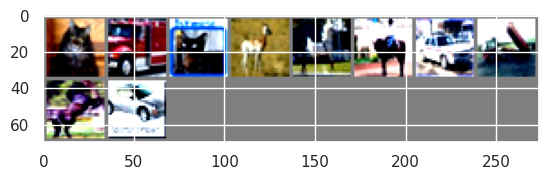

In [2]:
train_dataloader = get_dataloader('training')
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

* This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. 

* The remaining samples correspond to $\mathcal{X}$. 

* The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (0.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

Since we're only looking at a small part of the original training set, it's probable that some classes are more common than others, causing an imbalance. So, if a certain class is absent, we won't be able to measure how well the algorithm predicts it during training. We can only notice this during testing. Also, if we use a very complex model and train it with only a few samples, it might memorize spurious correlations and end up overfitting the training data.

$\textbf{Sanity check}:$ we check that even thought we only work with $100$ images, we still have a good representation of the classes.

Text(0.5, 1.0, 'Distribution of the classes in the training set')

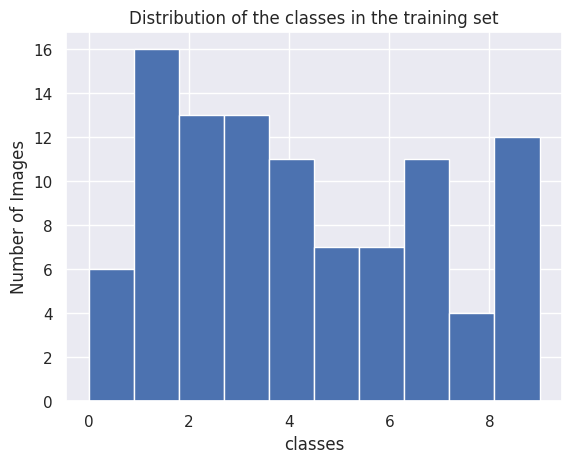

In [3]:
### sanity check 
labels = []
for img, label in train_dataloader:
    labels += label.tolist()

plt.hist(labels, bins = 10)
plt.xlabel('classes')
plt.ylabel('Number of Images')
plt.title('Distribution of the classes in the training set')
# plt.grid(True, linestyle='--', alpha=0.3)


We observe that most of the classes are well represented, except for the class 9.

# The Baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate scheduler (i.e. how to decrease the learning rate as a function of the number of epochs). A possible scheduler is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper (obviously, it is a different context for those researchers who had access to GPUs!) : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. 

## ResNet architectures

__Question 3 (2 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint :* You can re-use the following code : https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [4]:
def run_epoch(model, dataloader, criterion, optimizer, device, scheduler=None, verbose=True):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(dataloader, disable=not verbose):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    loss = running_loss / len(dataloader.dataset)
    accuracy = running_corrects.double() / len(dataloader.dataset)
    return loss, accuracy

def train(model, dataloader, test_loader, criterion, optimizer, device, epochs=10, scheduler=None, verbose=True):
    losses, losses_test = np.zeros(epochs), np.zeros(epochs)
    accuracies, accuracies_test = np.zeros(epochs), np.zeros(epochs)
    for epoch in range(epochs):
        if verbose: print(f'Epoch {epoch}/{epochs - 1}')
        loss, acc = run_epoch(model, dataloader, criterion, optimizer, device, scheduler=scheduler, verbose=verbose)
        loss_test, acc_test = test(model, test_loader, criterion, device, verbose)
        losses[epoch], losses_test[epoch] = loss, loss_test
        accuracies[epoch], accuracies_test[epoch] = acc, acc_test
        if verbose: 
            print(f'Finised epoch {epoch}/{epochs - 1}, loss: {loss:.4f}, acc: {acc:.4f}')
            print(f'Test metrics {epoch}/{epochs - 1}, loss: {loss_test:.4f}, acc: {acc_test:.4f}')
        if scheduler is not None:
            scheduler.step(acc_test)
    if verbose: print('Finished Training')
    return losses, accuracies, losses_test, accuracies_test

def test(model, dataloader, criterion, device, verbose=True):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, disable=not verbose):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        loss = running_loss / len(dataloader.dataset)
        accuracy = running_corrects.double() / len(dataloader.dataset)
        if verbose: print(f'Loss: {loss:.4f} Acc: {accuracy:.4f}')
    return loss, accuracy

In [22]:
lr = 0.001
max_epochs = 1

model = ResNet18().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.7)
criterion = torch.nn.CrossEntropyLoss()
train_dataloader = get_dataloader('training')
base_dataloader = get_dataloader('base')
test_dataloader = get_dataloader('testing')

losses, accuracies, losses_test, accuracies_test = train(model, train_dataloader, test_dataloader, criterion, optimizer, device, epochs=max_epochs, scheduler=scheduler)
# test_loss, test_acc = test(model, test_dataloader, criterion, device)
# print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 0/0


100%|██████████| 1000/1000 [00:03<00:00, 286.74it/s]

Loss: 11.3843 Acc: 0.1601
Finised epoch 0/0, loss: 2.8739, acc: 0.1500
Test metrics 0/0, loss: 11.3843, acc: 0.1601
Finished Training


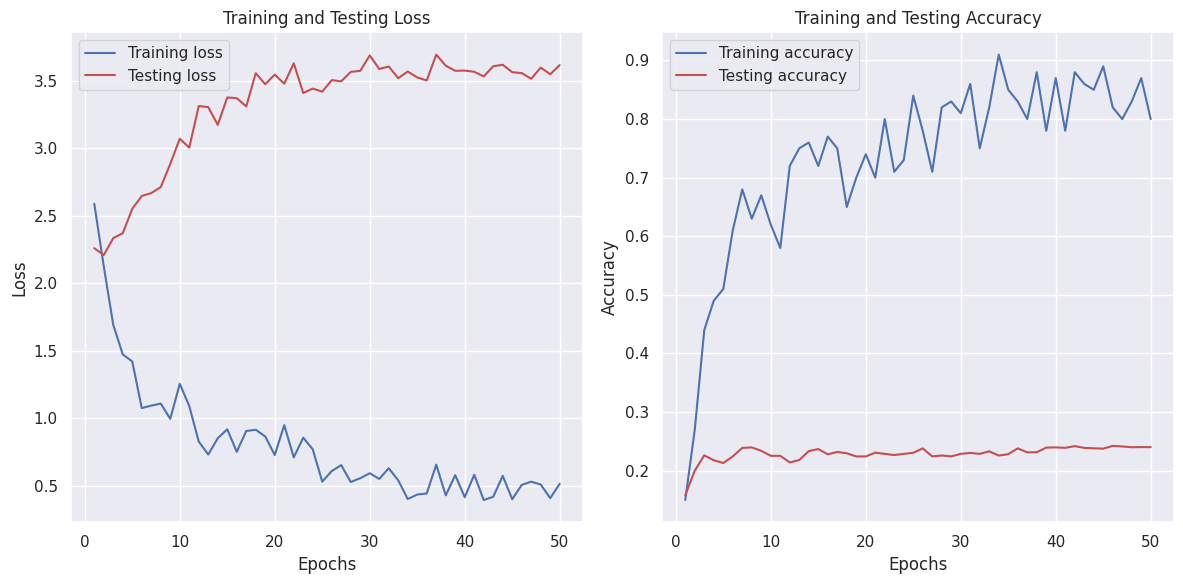

In [40]:
def plot_metrics(losses, losses_test, accuracies, accuracies_test):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(12, 6))

    # Plotting losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, 'b', label='Training loss')
    plt.plot(epochs, losses_test, 'r', label='Testing loss')
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, accuracies_test, 'r', label='Testing accuracy')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(losses, losses_test, accuracies, accuracies_test)

We notice that we managed to make our algorithm work better on the testing data. But, after a few rounds of training, the model starts to focus too much on the training data and doesn't get better on new data anymore.

| Model | Number of  epochs  | Train accuracy max/final | Test accuracy max/final |
|------|------|------|------|
|   ResNet18  | 30 | $99\%$ / $95\%$  | $25\%$ / $22,7\%$ |

| Model | Link | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|------|
|   ResNet18  | https://github.com/kuangliu/pytorch-cifar |  150 | $100\%$ | $93.02\%$ |

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on : https://pytorch.org/vision/stable/models.html.

__Question 4 (1 points):__ Pick a model from the list above, adapt it for CIFAR10 and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

#### $\textbf{Experience 1}$: Training for 50 epochs, only the final layers.  

In [38]:
model = torchvision.models.resnet18(weights='IMAGENET1K_V1').to(device)
# adapt it to cifar
freeze_weights(model)

model.fc = nn.Sequential(
    nn.Linear(512,256),
    nn.Linear(256,10)
)

### ensure the last layer is not freezed 

for layer in model.fc:
    for param in layer.parameters():
        param.requires_grad = True

model.to(device)

lr = 0.001
max_epochs = 50

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor=.5, patience = 10, min_lr = 1e-7)
criterion = torch.nn.CrossEntropyLoss()
losses, accuracies, losses_test, accuracies_test = train(model, train_dataloader, test_dataloader, criterion, optimizer, device, epochs=max_epochs, scheduler=scheduler)



Epoch 0/49


  3%|▎         | 29/1000 [00:00<00:03, 280.73it/s]

100%|██████████| 1000/1000 [00:03<00:00, 277.25it/s]


Loss: 2.2600 Acc: 0.1584
Finised epoch 0/49, loss: 2.5890, acc: 0.1500
Test metrics 0/49, loss: 2.2600, acc: 0.1584
Epoch 1/49


100%|██████████| 1000/1000 [00:03<00:00, 269.49it/s]


Loss: 2.2091 Acc: 0.2000
Finised epoch 1/49, loss: 2.1259, acc: 0.2700
Test metrics 1/49, loss: 2.2091, acc: 0.2000
Epoch 2/49


100%|██████████| 1000/1000 [00:03<00:00, 267.99it/s]


Loss: 2.3346 Acc: 0.2262
Finised epoch 2/49, loss: 1.6924, acc: 0.4400
Test metrics 2/49, loss: 2.3346, acc: 0.2262
Epoch 3/49


100%|██████████| 1000/1000 [00:03<00:00, 290.01it/s]


Loss: 2.3708 Acc: 0.2178
Finised epoch 3/49, loss: 1.4739, acc: 0.4900
Test metrics 3/49, loss: 2.3708, acc: 0.2178
Epoch 4/49


100%|██████████| 1000/1000 [00:03<00:00, 276.27it/s]


Loss: 2.5511 Acc: 0.2131
Finised epoch 4/49, loss: 1.4220, acc: 0.5100
Test metrics 4/49, loss: 2.5511, acc: 0.2131
Epoch 5/49


100%|██████████| 1000/1000 [00:03<00:00, 272.87it/s]


Loss: 2.6461 Acc: 0.2243
Finised epoch 5/49, loss: 1.0771, acc: 0.6100
Test metrics 5/49, loss: 2.6461, acc: 0.2243
Epoch 6/49


100%|██████████| 1000/1000 [00:03<00:00, 276.40it/s]


Loss: 2.6677 Acc: 0.2389
Finised epoch 6/49, loss: 1.0951, acc: 0.6800
Test metrics 6/49, loss: 2.6677, acc: 0.2389
Epoch 7/49


100%|██████████| 1000/1000 [00:03<00:00, 276.73it/s]


Loss: 2.7121 Acc: 0.2397
Finised epoch 7/49, loss: 1.1103, acc: 0.6300
Test metrics 7/49, loss: 2.7121, acc: 0.2397
Epoch 8/49


100%|██████████| 1000/1000 [00:03<00:00, 276.83it/s]


Loss: 2.8832 Acc: 0.2339
Finised epoch 8/49, loss: 0.9972, acc: 0.6700
Test metrics 8/49, loss: 2.8832, acc: 0.2339
Epoch 9/49


100%|██████████| 1000/1000 [00:03<00:00, 275.90it/s]


Loss: 3.0698 Acc: 0.2253
Finised epoch 9/49, loss: 1.2569, acc: 0.6200
Test metrics 9/49, loss: 3.0698, acc: 0.2253
Epoch 10/49


100%|██████████| 1000/1000 [00:03<00:00, 275.98it/s]


Loss: 3.0042 Acc: 0.2254
Finised epoch 10/49, loss: 1.0917, acc: 0.5800
Test metrics 10/49, loss: 3.0042, acc: 0.2254
Epoch 11/49


100%|██████████| 1000/1000 [00:03<00:00, 277.14it/s]


Loss: 3.3117 Acc: 0.2141
Finised epoch 11/49, loss: 0.8288, acc: 0.7200
Test metrics 11/49, loss: 3.3117, acc: 0.2141
Epoch 12/49


100%|██████████| 1000/1000 [00:03<00:00, 278.24it/s]


Loss: 3.3036 Acc: 0.2181
Finised epoch 12/49, loss: 0.7334, acc: 0.7500
Test metrics 12/49, loss: 3.3036, acc: 0.2181
Epoch 13/49


100%|██████████| 1000/1000 [00:03<00:00, 277.65it/s]


Loss: 3.1722 Acc: 0.2334
Finised epoch 13/49, loss: 0.8540, acc: 0.7600
Test metrics 13/49, loss: 3.1722, acc: 0.2334
Epoch 14/49


100%|██████████| 1000/1000 [00:03<00:00, 278.13it/s]


Loss: 3.3750 Acc: 0.2369
Finised epoch 14/49, loss: 0.9200, acc: 0.7200
Test metrics 14/49, loss: 3.3750, acc: 0.2369
Epoch 15/49


100%|██████████| 1000/1000 [00:03<00:00, 277.41it/s]


Loss: 3.3703 Acc: 0.2279
Finised epoch 15/49, loss: 0.7530, acc: 0.7700
Test metrics 15/49, loss: 3.3703, acc: 0.2279
Epoch 16/49


100%|██████████| 1000/1000 [00:03<00:00, 277.41it/s]


Loss: 3.3091 Acc: 0.2319
Finised epoch 16/49, loss: 0.9073, acc: 0.7500
Test metrics 16/49, loss: 3.3091, acc: 0.2319
Epoch 17/49


100%|██████████| 1000/1000 [00:03<00:00, 277.74it/s]


Loss: 3.5549 Acc: 0.2297
Finised epoch 17/49, loss: 0.9166, acc: 0.6500
Test metrics 17/49, loss: 3.5549, acc: 0.2297
Epoch 18/49


100%|██████████| 1000/1000 [00:03<00:00, 278.21it/s]


Loss: 3.4732 Acc: 0.2243
Finised epoch 18/49, loss: 0.8669, acc: 0.7000
Test metrics 18/49, loss: 3.4732, acc: 0.2243
Epoch 19/49


100%|██████████| 1000/1000 [00:03<00:00, 277.95it/s]


Loss: 3.5444 Acc: 0.2243
Finised epoch 19/49, loss: 0.7296, acc: 0.7400
Test metrics 19/49, loss: 3.5444, acc: 0.2243
Epoch 20/49


100%|██████████| 1000/1000 [00:03<00:00, 276.90it/s]


Loss: 3.4771 Acc: 0.2308
Finised epoch 20/49, loss: 0.9509, acc: 0.7000
Test metrics 20/49, loss: 3.4771, acc: 0.2308
Epoch 21/49


100%|██████████| 1000/1000 [00:03<00:00, 277.61it/s]


Loss: 3.6283 Acc: 0.2287
Finised epoch 21/49, loss: 0.7123, acc: 0.8000
Test metrics 21/49, loss: 3.6283, acc: 0.2287
Epoch 22/49


100%|██████████| 1000/1000 [00:03<00:00, 277.44it/s]


Loss: 3.4081 Acc: 0.2267
Finised epoch 22/49, loss: 0.8578, acc: 0.7100
Test metrics 22/49, loss: 3.4081, acc: 0.2267
Epoch 23/49


100%|██████████| 1000/1000 [00:03<00:00, 278.04it/s]


Loss: 3.4409 Acc: 0.2286
Finised epoch 23/49, loss: 0.7717, acc: 0.7300
Test metrics 23/49, loss: 3.4409, acc: 0.2286
Epoch 24/49


100%|██████████| 1000/1000 [00:03<00:00, 277.56it/s]


Loss: 3.4183 Acc: 0.2305
Finised epoch 24/49, loss: 0.5326, acc: 0.8400
Test metrics 24/49, loss: 3.4183, acc: 0.2305
Epoch 25/49


100%|██████████| 1000/1000 [00:03<00:00, 277.66it/s]


Loss: 3.5035 Acc: 0.2380
Finised epoch 25/49, loss: 0.6109, acc: 0.7800
Test metrics 25/49, loss: 3.5035, acc: 0.2380
Epoch 26/49


100%|██████████| 1000/1000 [00:03<00:00, 277.41it/s]


Loss: 3.4946 Acc: 0.2244
Finised epoch 26/49, loss: 0.6548, acc: 0.7100
Test metrics 26/49, loss: 3.4946, acc: 0.2244
Epoch 27/49


100%|██████████| 1000/1000 [00:03<00:00, 278.33it/s]


Loss: 3.5645 Acc: 0.2259
Finised epoch 27/49, loss: 0.5300, acc: 0.8200
Test metrics 27/49, loss: 3.5645, acc: 0.2259
Epoch 28/49


100%|██████████| 1000/1000 [00:03<00:00, 277.19it/s]


Loss: 3.5723 Acc: 0.2244
Finised epoch 28/49, loss: 0.5581, acc: 0.8300
Test metrics 28/49, loss: 3.5723, acc: 0.2244
Epoch 29/49


100%|██████████| 1000/1000 [00:03<00:00, 295.14it/s]


Loss: 3.6864 Acc: 0.2287
Finised epoch 29/49, loss: 0.5951, acc: 0.8100
Test metrics 29/49, loss: 3.6864, acc: 0.2287
Epoch 30/49


100%|██████████| 1000/1000 [00:03<00:00, 298.22it/s]


Loss: 3.5857 Acc: 0.2303
Finised epoch 30/49, loss: 0.5526, acc: 0.8600
Test metrics 30/49, loss: 3.5857, acc: 0.2303
Epoch 31/49


100%|██████████| 1000/1000 [00:03<00:00, 296.96it/s]


Loss: 3.6043 Acc: 0.2287
Finised epoch 31/49, loss: 0.6319, acc: 0.7500
Test metrics 31/49, loss: 3.6043, acc: 0.2287
Epoch 32/49


100%|██████████| 1000/1000 [00:03<00:00, 295.95it/s]


Loss: 3.5180 Acc: 0.2330
Finised epoch 32/49, loss: 0.5421, acc: 0.8200
Test metrics 32/49, loss: 3.5180, acc: 0.2330
Epoch 33/49


100%|██████████| 1000/1000 [00:03<00:00, 296.88it/s]


Loss: 3.5672 Acc: 0.2258
Finised epoch 33/49, loss: 0.4042, acc: 0.9100
Test metrics 33/49, loss: 3.5672, acc: 0.2258
Epoch 34/49


100%|██████████| 1000/1000 [00:03<00:00, 297.05it/s]


Loss: 3.5234 Acc: 0.2281
Finised epoch 34/49, loss: 0.4372, acc: 0.8500
Test metrics 34/49, loss: 3.5234, acc: 0.2281
Epoch 35/49


100%|██████████| 1000/1000 [00:03<00:00, 297.53it/s]


Loss: 3.5009 Acc: 0.2381
Finised epoch 35/49, loss: 0.4451, acc: 0.8300
Test metrics 35/49, loss: 3.5009, acc: 0.2381
Epoch 36/49


100%|██████████| 1000/1000 [00:03<00:00, 297.45it/s]


Loss: 3.6924 Acc: 0.2313
Finised epoch 36/49, loss: 0.6586, acc: 0.8000
Test metrics 36/49, loss: 3.6924, acc: 0.2313
Epoch 37/49


100%|██████████| 1000/1000 [00:03<00:00, 297.84it/s]


Loss: 3.6105 Acc: 0.2314
Finised epoch 37/49, loss: 0.4313, acc: 0.8800
Test metrics 37/49, loss: 3.6105, acc: 0.2314
Epoch 38/49


100%|██████████| 1000/1000 [00:03<00:00, 297.91it/s]


Loss: 3.5726 Acc: 0.2394
Finised epoch 38/49, loss: 0.5808, acc: 0.7800
Test metrics 38/49, loss: 3.5726, acc: 0.2394
Epoch 39/49


100%|██████████| 1000/1000 [00:03<00:00, 298.20it/s]


Loss: 3.5743 Acc: 0.2397
Finised epoch 39/49, loss: 0.4174, acc: 0.8700
Test metrics 39/49, loss: 3.5743, acc: 0.2397
Epoch 40/49


100%|██████████| 1000/1000 [00:03<00:00, 297.87it/s]


Loss: 3.5652 Acc: 0.2390
Finised epoch 40/49, loss: 0.5835, acc: 0.7800
Test metrics 40/49, loss: 3.5652, acc: 0.2390
Epoch 41/49


100%|██████████| 1000/1000 [00:03<00:00, 297.82it/s]


Loss: 3.5307 Acc: 0.2419
Finised epoch 41/49, loss: 0.3970, acc: 0.8800
Test metrics 41/49, loss: 3.5307, acc: 0.2419
Epoch 42/49


100%|██████████| 1000/1000 [00:03<00:00, 297.69it/s]


Loss: 3.6065 Acc: 0.2389
Finised epoch 42/49, loss: 0.4206, acc: 0.8600
Test metrics 42/49, loss: 3.6065, acc: 0.2389
Epoch 43/49


100%|██████████| 1000/1000 [00:03<00:00, 298.52it/s]


Loss: 3.6170 Acc: 0.2382
Finised epoch 43/49, loss: 0.5757, acc: 0.8500
Test metrics 43/49, loss: 3.6170, acc: 0.2382
Epoch 44/49


100%|██████████| 1000/1000 [00:03<00:00, 297.97it/s]


Loss: 3.5622 Acc: 0.2376
Finised epoch 44/49, loss: 0.4027, acc: 0.8900
Test metrics 44/49, loss: 3.5622, acc: 0.2376
Epoch 45/49


100%|██████████| 1000/1000 [00:03<00:00, 297.25it/s]


Loss: 3.5556 Acc: 0.2423
Finised epoch 45/49, loss: 0.5085, acc: 0.8200
Test metrics 45/49, loss: 3.5556, acc: 0.2423
Epoch 46/49


100%|██████████| 1000/1000 [00:03<00:00, 297.97it/s]


Loss: 3.5136 Acc: 0.2413
Finised epoch 46/49, loss: 0.5324, acc: 0.8000
Test metrics 46/49, loss: 3.5136, acc: 0.2413
Epoch 47/49


100%|██████████| 1000/1000 [00:03<00:00, 297.53it/s]


Loss: 3.5963 Acc: 0.2400
Finised epoch 47/49, loss: 0.5113, acc: 0.8300
Test metrics 47/49, loss: 3.5963, acc: 0.2400
Epoch 48/49


100%|██████████| 1000/1000 [00:03<00:00, 297.97it/s]


Loss: 3.5470 Acc: 0.2403
Finised epoch 48/49, loss: 0.4106, acc: 0.8700
Test metrics 48/49, loss: 3.5470, acc: 0.2403
Epoch 49/49


100%|██████████| 1000/1000 [00:03<00:00, 297.71it/s]

Loss: 3.6148 Acc: 0.2401
Finised epoch 49/49, loss: 0.5173, acc: 0.8000
Test metrics 49/49, loss: 3.6148, acc: 0.2401
Finished Training


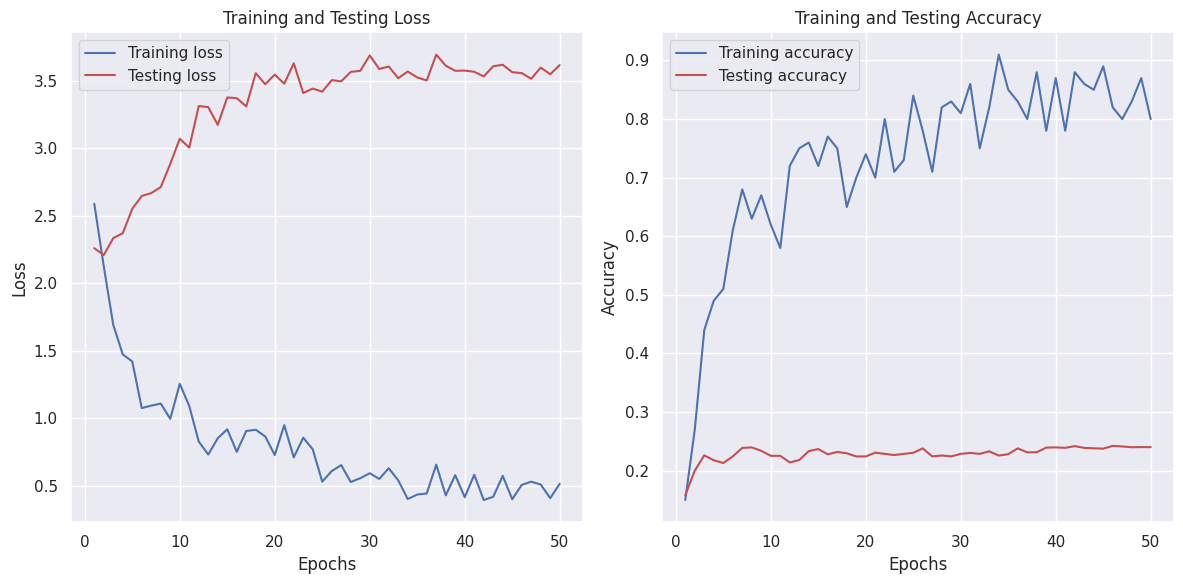

In [41]:
plot_metrics(losses, losses_test, accuracies, accuracies_test)

#### $\textbf{Experience 2}$: Training for 50 epochs, training all the layers.  

In [43]:
model = torchvision.models.resnet18(weights='IMAGENET1K_V1').to(device)
# adapt it to cifar
# freeze_weights(model)

model.fc = nn.Sequential(
    nn.Linear(512,256),
    nn.Linear(256,10)
)

### ensure the last layer is not freezed 

for layer in model.fc:
    for param in layer.parameters():
        param.requires_grad = True

model.to(device)

lr = 0.001
max_epochs = 50

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor=.5, patience = 10, min_lr = 1e-7)
criterion = torch.nn.CrossEntropyLoss()
losses, accuracies, losses_test, accuracies_test = train(model, train_dataloader, test_dataloader, criterion, optimizer, device, epochs=max_epochs, scheduler=scheduler)



Epoch 0/49


100%|██████████| 1000/1000 [00:03<00:00, 297.57it/s]


Loss: 3.2783 Acc: 0.1834
Finised epoch 0/49, loss: 2.7329, acc: 0.1600
Test metrics 0/49, loss: 3.2783, acc: 0.1834
Epoch 1/49


100%|██████████| 1000/1000 [00:03<00:00, 298.70it/s]


Loss: 3.3884 Acc: 0.2467
Finised epoch 1/49, loss: 2.0062, acc: 0.3600
Test metrics 1/49, loss: 3.3884, acc: 0.2467
Epoch 2/49


100%|██████████| 1000/1000 [00:03<00:00, 297.71it/s]


Loss: 2.8073 Acc: 0.2240
Finised epoch 2/49, loss: 1.4863, acc: 0.5800
Test metrics 2/49, loss: 2.8073, acc: 0.2240
Epoch 3/49


100%|██████████| 1000/1000 [00:03<00:00, 297.46it/s]


Loss: 2.8239 Acc: 0.2618
Finised epoch 3/49, loss: 1.0839, acc: 0.6800
Test metrics 3/49, loss: 2.8239, acc: 0.2618
Epoch 4/49


100%|██████████| 1000/1000 [00:03<00:00, 298.28it/s]


Loss: 3.1580 Acc: 0.2553
Finised epoch 4/49, loss: 1.0751, acc: 0.6600
Test metrics 4/49, loss: 3.1580, acc: 0.2553
Epoch 5/49


100%|██████████| 1000/1000 [00:03<00:00, 298.47it/s]


Loss: 3.1413 Acc: 0.2596
Finised epoch 5/49, loss: 1.1184, acc: 0.6600
Test metrics 5/49, loss: 3.1413, acc: 0.2596
Epoch 6/49


100%|██████████| 1000/1000 [00:03<00:00, 299.16it/s]


Loss: 2.9955 Acc: 0.2716
Finised epoch 6/49, loss: 0.8622, acc: 0.7900
Test metrics 6/49, loss: 2.9955, acc: 0.2716
Epoch 7/49


100%|██████████| 1000/1000 [00:03<00:00, 298.65it/s]


Loss: 2.5290 Acc: 0.3094
Finised epoch 7/49, loss: 0.7486, acc: 0.7500
Test metrics 7/49, loss: 2.5290, acc: 0.3094
Epoch 8/49


100%|██████████| 1000/1000 [00:03<00:00, 295.52it/s]


Loss: 2.8000 Acc: 0.3027
Finised epoch 8/49, loss: 0.8466, acc: 0.7600
Test metrics 8/49, loss: 2.8000, acc: 0.3027
Epoch 9/49


100%|██████████| 1000/1000 [00:03<00:00, 294.57it/s]


Loss: 2.8988 Acc: 0.2753
Finised epoch 9/49, loss: 0.8388, acc: 0.7300
Test metrics 9/49, loss: 2.8988, acc: 0.2753
Epoch 10/49


100%|██████████| 1000/1000 [00:03<00:00, 295.22it/s]


Loss: 2.7527 Acc: 0.3045
Finised epoch 10/49, loss: 0.8325, acc: 0.7800
Test metrics 10/49, loss: 2.7527, acc: 0.3045
Epoch 11/49


100%|██████████| 1000/1000 [00:03<00:00, 295.66it/s]


Loss: 2.5025 Acc: 0.2996
Finised epoch 11/49, loss: 0.7927, acc: 0.7700
Test metrics 11/49, loss: 2.5025, acc: 0.2996
Epoch 12/49


100%|██████████| 1000/1000 [00:03<00:00, 295.55it/s]


Loss: 2.6864 Acc: 0.2717
Finised epoch 12/49, loss: 0.9020, acc: 0.7500
Test metrics 12/49, loss: 2.6864, acc: 0.2717
Epoch 13/49


100%|██████████| 1000/1000 [00:03<00:00, 299.10it/s]


Loss: 2.5468 Acc: 0.2905
Finised epoch 13/49, loss: 0.8302, acc: 0.7400
Test metrics 13/49, loss: 2.5468, acc: 0.2905
Epoch 14/49


100%|██████████| 1000/1000 [00:03<00:00, 298.59it/s]


Loss: 2.5215 Acc: 0.2979
Finised epoch 14/49, loss: 0.5802, acc: 0.8100
Test metrics 14/49, loss: 2.5215, acc: 0.2979
Epoch 15/49


100%|██████████| 1000/1000 [00:03<00:00, 297.10it/s]


Loss: 2.5638 Acc: 0.3214
Finised epoch 15/49, loss: 0.3802, acc: 0.9300
Test metrics 15/49, loss: 2.5638, acc: 0.3214
Epoch 16/49


100%|██████████| 1000/1000 [00:03<00:00, 298.10it/s]


Loss: 2.4210 Acc: 0.3401
Finised epoch 16/49, loss: 0.6179, acc: 0.8200
Test metrics 16/49, loss: 2.4210, acc: 0.3401
Epoch 17/49


100%|██████████| 1000/1000 [00:03<00:00, 298.88it/s]


Loss: 2.7121 Acc: 0.3016
Finised epoch 17/49, loss: 0.7023, acc: 0.7700
Test metrics 17/49, loss: 2.7121, acc: 0.3016
Epoch 18/49


100%|██████████| 1000/1000 [00:03<00:00, 298.04it/s]


Loss: 2.6280 Acc: 0.2937
Finised epoch 18/49, loss: 0.4913, acc: 0.8600
Test metrics 18/49, loss: 2.6280, acc: 0.2937
Epoch 19/49


100%|██████████| 1000/1000 [00:03<00:00, 298.41it/s]


Loss: 2.6704 Acc: 0.2939
Finised epoch 19/49, loss: 0.6750, acc: 0.8100
Test metrics 19/49, loss: 2.6704, acc: 0.2939
Epoch 20/49


100%|██████████| 1000/1000 [00:03<00:00, 298.94it/s]


Loss: 2.5675 Acc: 0.3018
Finised epoch 20/49, loss: 0.6309, acc: 0.8000
Test metrics 20/49, loss: 2.5675, acc: 0.3018
Epoch 21/49


100%|██████████| 1000/1000 [00:03<00:00, 298.04it/s]


Loss: 2.4547 Acc: 0.3028
Finised epoch 21/49, loss: 0.5473, acc: 0.8200
Test metrics 21/49, loss: 2.4547, acc: 0.3028
Epoch 22/49


100%|██████████| 1000/1000 [00:03<00:00, 298.37it/s]


Loss: 3.0502 Acc: 0.3000
Finised epoch 22/49, loss: 0.9443, acc: 0.7500
Test metrics 22/49, loss: 3.0502, acc: 0.3000
Epoch 23/49


100%|██████████| 1000/1000 [00:03<00:00, 298.69it/s]


Loss: 2.8964 Acc: 0.2919
Finised epoch 23/49, loss: 0.8042, acc: 0.7400
Test metrics 23/49, loss: 2.8964, acc: 0.2919
Epoch 24/49


100%|██████████| 1000/1000 [00:03<00:00, 298.01it/s]


Loss: 3.0496 Acc: 0.2842
Finised epoch 24/49, loss: 0.6048, acc: 0.8200
Test metrics 24/49, loss: 3.0496, acc: 0.2842
Epoch 25/49


100%|██████████| 1000/1000 [00:03<00:00, 297.95it/s]


Loss: 2.6294 Acc: 0.2941
Finised epoch 25/49, loss: 0.6105, acc: 0.7900
Test metrics 25/49, loss: 2.6294, acc: 0.2941
Epoch 26/49


100%|██████████| 1000/1000 [00:03<00:00, 297.61it/s]


Loss: 2.5052 Acc: 0.3311
Finised epoch 26/49, loss: 0.5705, acc: 0.8400
Test metrics 26/49, loss: 2.5052, acc: 0.3311
Epoch 27/49


100%|██████████| 1000/1000 [00:03<00:00, 297.14it/s]


Loss: 2.5531 Acc: 0.2907
Finised epoch 27/49, loss: 0.6189, acc: 0.8000
Test metrics 27/49, loss: 2.5531, acc: 0.2907
Epoch 28/49


100%|██████████| 1000/1000 [00:03<00:00, 298.04it/s]


Loss: 2.5614 Acc: 0.2915
Finised epoch 28/49, loss: 0.4223, acc: 0.8400
Test metrics 28/49, loss: 2.5614, acc: 0.2915
Epoch 29/49


100%|██████████| 1000/1000 [00:03<00:00, 293.74it/s]


Loss: 2.4893 Acc: 0.2947
Finised epoch 29/49, loss: 0.3127, acc: 0.8800
Test metrics 29/49, loss: 2.4893, acc: 0.2947
Epoch 30/49


100%|██████████| 1000/1000 [00:03<00:00, 295.30it/s]


Loss: 2.4749 Acc: 0.3047
Finised epoch 30/49, loss: 0.1536, acc: 0.9500
Test metrics 30/49, loss: 2.4749, acc: 0.3047
Epoch 31/49


100%|██████████| 1000/1000 [00:03<00:00, 296.50it/s]


Loss: 2.3392 Acc: 0.3278
Finised epoch 31/49, loss: 0.1261, acc: 0.9800
Test metrics 31/49, loss: 2.3392, acc: 0.3278
Epoch 32/49


100%|██████████| 1000/1000 [00:03<00:00, 298.12it/s]


Loss: 2.3086 Acc: 0.3262
Finised epoch 32/49, loss: 0.2025, acc: 0.9300
Test metrics 32/49, loss: 2.3086, acc: 0.3262
Epoch 33/49


100%|██████████| 1000/1000 [00:03<00:00, 295.56it/s]


Loss: 2.3806 Acc: 0.3132
Finised epoch 33/49, loss: 0.1635, acc: 0.9400
Test metrics 33/49, loss: 2.3806, acc: 0.3132
Epoch 34/49


100%|██████████| 1000/1000 [00:03<00:00, 297.59it/s]


Loss: 2.5177 Acc: 0.2918
Finised epoch 34/49, loss: 0.2551, acc: 0.9300
Test metrics 34/49, loss: 2.5177, acc: 0.2918
Epoch 35/49


100%|██████████| 1000/1000 [00:03<00:00, 298.41it/s]


Loss: 2.4239 Acc: 0.3062
Finised epoch 35/49, loss: 0.2679, acc: 0.9300
Test metrics 35/49, loss: 2.4239, acc: 0.3062
Epoch 36/49


100%|██████████| 1000/1000 [00:03<00:00, 297.42it/s]


Loss: 2.4316 Acc: 0.3059
Finised epoch 36/49, loss: 0.1941, acc: 0.9400
Test metrics 36/49, loss: 2.4316, acc: 0.3059
Epoch 37/49


100%|██████████| 1000/1000 [00:03<00:00, 299.24it/s]


Loss: 2.5562 Acc: 0.2966
Finised epoch 37/49, loss: 0.1105, acc: 0.9800
Test metrics 37/49, loss: 2.5562, acc: 0.2966
Epoch 38/49


100%|██████████| 1000/1000 [00:03<00:00, 296.80it/s]


Loss: 2.4809 Acc: 0.3088
Finised epoch 38/49, loss: 0.1187, acc: 0.9700
Test metrics 38/49, loss: 2.4809, acc: 0.3088
Epoch 39/49


100%|██████████| 1000/1000 [00:03<00:00, 294.66it/s]


Loss: 2.4268 Acc: 0.3087
Finised epoch 39/49, loss: 0.0899, acc: 0.9700
Test metrics 39/49, loss: 2.4268, acc: 0.3087
Epoch 40/49


100%|██████████| 1000/1000 [00:03<00:00, 295.58it/s]


Loss: 2.5383 Acc: 0.3050
Finised epoch 40/49, loss: 0.0685, acc: 0.9800
Test metrics 40/49, loss: 2.5383, acc: 0.3050
Epoch 41/49


100%|██████████| 1000/1000 [00:03<00:00, 295.28it/s]


Loss: 2.4488 Acc: 0.3121
Finised epoch 41/49, loss: 0.0967, acc: 0.9700
Test metrics 41/49, loss: 2.4488, acc: 0.3121
Epoch 42/49


100%|██████████| 1000/1000 [00:03<00:00, 279.28it/s]


Loss: 2.4235 Acc: 0.3213
Finised epoch 42/49, loss: 0.1218, acc: 0.9600
Test metrics 42/49, loss: 2.4235, acc: 0.3213
Epoch 43/49


100%|██████████| 1000/1000 [00:03<00:00, 289.58it/s]


Loss: 2.4021 Acc: 0.3336
Finised epoch 43/49, loss: 0.0722, acc: 0.9900
Test metrics 43/49, loss: 2.4021, acc: 0.3336
Epoch 44/49


100%|██████████| 1000/1000 [00:03<00:00, 289.50it/s]


Loss: 2.4006 Acc: 0.3295
Finised epoch 44/49, loss: 0.0492, acc: 0.9900
Test metrics 44/49, loss: 2.4006, acc: 0.3295
Epoch 45/49


100%|██████████| 1000/1000 [00:03<00:00, 292.03it/s]


Loss: 2.3976 Acc: 0.3287
Finised epoch 45/49, loss: 0.0172, acc: 1.0000
Test metrics 45/49, loss: 2.3976, acc: 0.3287
Epoch 46/49


100%|██████████| 1000/1000 [00:03<00:00, 296.71it/s]


Loss: 2.4937 Acc: 0.3208
Finised epoch 46/49, loss: 0.1056, acc: 0.9600
Test metrics 46/49, loss: 2.4937, acc: 0.3208
Epoch 47/49


100%|██████████| 1000/1000 [00:03<00:00, 295.90it/s]


Loss: 2.5201 Acc: 0.3206
Finised epoch 47/49, loss: 0.0251, acc: 0.9900
Test metrics 47/49, loss: 2.5201, acc: 0.3206
Epoch 48/49


100%|██████████| 1000/1000 [00:03<00:00, 296.66it/s]


Loss: 2.5447 Acc: 0.3244
Finised epoch 48/49, loss: 0.0241, acc: 1.0000
Test metrics 48/49, loss: 2.5447, acc: 0.3244
Epoch 49/49


100%|██████████| 1000/1000 [00:03<00:00, 296.05it/s]

Loss: 2.5631 Acc: 0.3230
Finised epoch 49/49, loss: 0.0262, acc: 1.0000
Test metrics 49/49, loss: 2.5631, acc: 0.3230
Finished Training


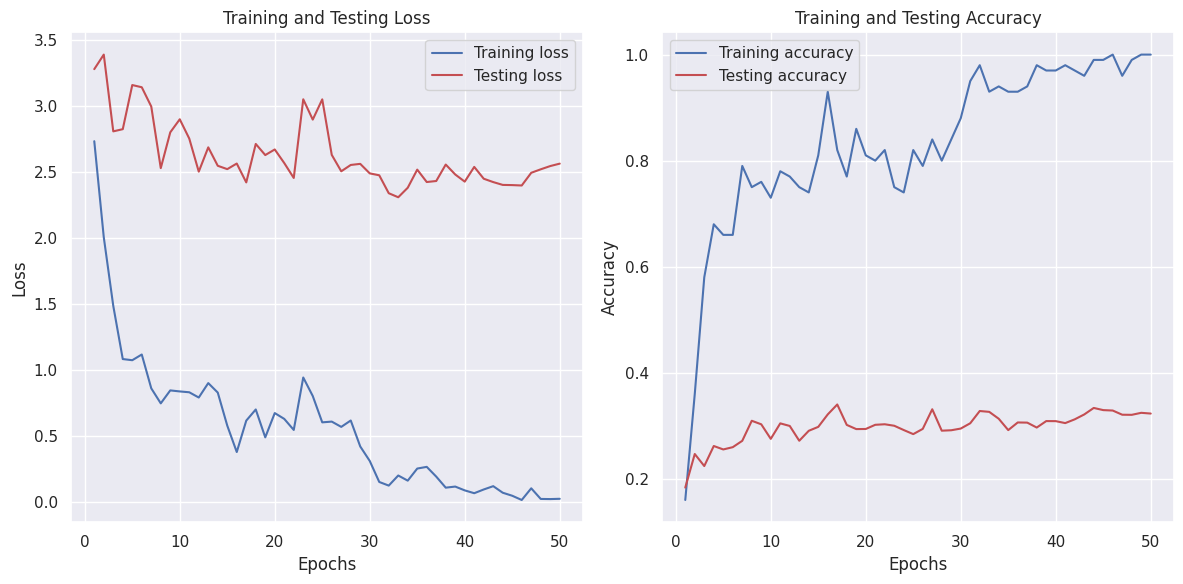

In [45]:
plot_metrics(losses, losses_test, accuracies, accuracies_test)

#### $\textbf{Experience 3}$: Training for 50 epochs, training only the last layers and Resizing the images.

In [48]:
### resize the images 

transformations = transforms.Compose([transforms.Resize((224,224), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=MEAN, std=STD_DEV)])

train_dataloader = get_dataloader('training', transformations=transformations)
base_dataloader = get_dataloader('base', transformations=transformations)
test_dataloader = get_dataloader('testing', transformations=transformations)


model = torchvision.models.resnet18(weights='IMAGENET1K_V1').to(device)
# adapt it to cifar
freeze_weights(model)

model.fc = nn.Sequential(
    nn.Linear(512,256),
    nn.Linear(256,10)
)

### ensure the last layer is not freezed 

for layer in model.fc:
    for param in layer.parameters():
        param.requires_grad = True

model.to(device)

lr = 0.001
max_epochs = 50

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor=.5, patience = 10, min_lr = 1e-7)
criterion = torch.nn.CrossEntropyLoss()
losses, accuracies, losses_test, accuracies_test = train(model, train_dataloader, test_dataloader, criterion, optimizer, device, epochs=max_epochs, scheduler=scheduler)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 0/49


100%|██████████| 1000/1000 [00:09<00:00, 101.60it/s]


Loss: 2.1688 Acc: 0.2503
Finised epoch 0/49, loss: 2.5880, acc: 0.0800
Test metrics 0/49, loss: 2.1688, acc: 0.2503
Epoch 1/49


100%|██████████| 1000/1000 [00:09<00:00, 100.72it/s]


Loss: 1.8555 Acc: 0.2950
Finised epoch 1/49, loss: 1.9026, acc: 0.3800
Test metrics 1/49, loss: 1.8555, acc: 0.2950
Epoch 2/49


100%|██████████| 1000/1000 [00:10<00:00, 99.32it/s]


Loss: 1.8464 Acc: 0.3637
Finised epoch 2/49, loss: 1.5165, acc: 0.4500
Test metrics 2/49, loss: 1.8464, acc: 0.3637
Epoch 3/49


100%|██████████| 1000/1000 [00:09<00:00, 100.44it/s]


Loss: 1.5330 Acc: 0.4730
Finised epoch 3/49, loss: 1.1172, acc: 0.7000
Test metrics 3/49, loss: 1.5330, acc: 0.4730
Epoch 4/49


100%|██████████| 1000/1000 [00:09<00:00, 100.20it/s]


Loss: 1.5254 Acc: 0.4534
Finised epoch 4/49, loss: 0.8955, acc: 0.7600
Test metrics 4/49, loss: 1.5254, acc: 0.4534
Epoch 5/49


100%|██████████| 1000/1000 [00:10<00:00, 99.56it/s]


Loss: 1.3955 Acc: 0.5230
Finised epoch 5/49, loss: 0.6373, acc: 0.8700
Test metrics 5/49, loss: 1.3955, acc: 0.5230
Epoch 6/49


100%|██████████| 1000/1000 [00:09<00:00, 102.11it/s]


Loss: 1.3626 Acc: 0.5142
Finised epoch 6/49, loss: 0.4927, acc: 0.9000
Test metrics 6/49, loss: 1.3626, acc: 0.5142
Epoch 7/49


100%|██████████| 1000/1000 [00:09<00:00, 104.18it/s]


Loss: 1.3124 Acc: 0.5419
Finised epoch 7/49, loss: 0.4368, acc: 0.9500
Test metrics 7/49, loss: 1.3124, acc: 0.5419
Epoch 8/49


100%|██████████| 1000/1000 [00:09<00:00, 103.13it/s]


Loss: 1.3839 Acc: 0.5236
Finised epoch 8/49, loss: 0.3453, acc: 0.9800
Test metrics 8/49, loss: 1.3839, acc: 0.5236
Epoch 9/49


100%|██████████| 1000/1000 [00:09<00:00, 104.81it/s]


Loss: 1.4015 Acc: 0.5079
Finised epoch 9/49, loss: 0.3533, acc: 0.9300
Test metrics 9/49, loss: 1.4015, acc: 0.5079
Epoch 10/49


100%|██████████| 1000/1000 [00:09<00:00, 106.68it/s]


Loss: 1.2576 Acc: 0.5673
Finised epoch 10/49, loss: 0.2758, acc: 0.9600
Test metrics 10/49, loss: 1.2576, acc: 0.5673
Epoch 11/49


100%|██████████| 1000/1000 [00:09<00:00, 107.55it/s]


Loss: 1.4024 Acc: 0.5100
Finised epoch 11/49, loss: 0.2449, acc: 0.9600
Test metrics 11/49, loss: 1.4024, acc: 0.5100
Epoch 12/49


100%|██████████| 1000/1000 [00:09<00:00, 107.19it/s]


Loss: 1.3707 Acc: 0.5414
Finised epoch 12/49, loss: 0.2619, acc: 0.9200
Test metrics 12/49, loss: 1.3707, acc: 0.5414
Epoch 13/49


100%|██████████| 1000/1000 [00:09<00:00, 103.58it/s]


Loss: 1.3712 Acc: 0.5328
Finised epoch 13/49, loss: 0.1832, acc: 0.9800
Test metrics 13/49, loss: 1.3712, acc: 0.5328
Epoch 14/49


100%|██████████| 1000/1000 [00:09<00:00, 110.44it/s]


Loss: 1.5188 Acc: 0.5024
Finised epoch 14/49, loss: 0.1446, acc: 1.0000
Test metrics 14/49, loss: 1.5188, acc: 0.5024
Epoch 15/49


100%|██████████| 1000/1000 [00:09<00:00, 110.62it/s]


Loss: 1.3059 Acc: 0.5604
Finised epoch 15/49, loss: 0.1648, acc: 0.9700
Test metrics 15/49, loss: 1.3059, acc: 0.5604
Epoch 16/49


100%|██████████| 1000/1000 [00:08<00:00, 111.36it/s]


Loss: 1.6232 Acc: 0.4927
Finised epoch 16/49, loss: 0.1487, acc: 0.9700
Test metrics 16/49, loss: 1.6232, acc: 0.4927
Epoch 17/49


100%|██████████| 1000/1000 [00:09<00:00, 110.15it/s]


Loss: 1.4998 Acc: 0.5309
Finised epoch 17/49, loss: 0.1061, acc: 0.9800
Test metrics 17/49, loss: 1.4998, acc: 0.5309
Epoch 18/49


100%|██████████| 1000/1000 [00:09<00:00, 109.68it/s]


Loss: 1.7991 Acc: 0.4695
Finised epoch 18/49, loss: 0.1386, acc: 0.9400
Test metrics 18/49, loss: 1.7991, acc: 0.4695
Epoch 19/49


100%|██████████| 1000/1000 [00:09<00:00, 110.96it/s]


Loss: 1.3900 Acc: 0.5479
Finised epoch 19/49, loss: 0.1176, acc: 0.9800
Test metrics 19/49, loss: 1.3900, acc: 0.5479
Epoch 20/49


100%|██████████| 1000/1000 [00:09<00:00, 110.87it/s]


Loss: 1.4218 Acc: 0.5463
Finised epoch 20/49, loss: 0.0725, acc: 0.9900
Test metrics 20/49, loss: 1.4218, acc: 0.5463
Epoch 21/49


100%|██████████| 1000/1000 [00:09<00:00, 110.60it/s]


Loss: 1.6675 Acc: 0.4926
Finised epoch 21/49, loss: 0.0643, acc: 1.0000
Test metrics 21/49, loss: 1.6675, acc: 0.4926
Epoch 22/49


100%|██████████| 1000/1000 [00:08<00:00, 111.21it/s]


Loss: 1.4479 Acc: 0.5433
Finised epoch 22/49, loss: 0.0976, acc: 0.9800
Test metrics 22/49, loss: 1.4479, acc: 0.5433
Epoch 23/49


100%|██████████| 1000/1000 [00:08<00:00, 111.37it/s]


Loss: 1.3853 Acc: 0.5585
Finised epoch 23/49, loss: 0.0705, acc: 1.0000
Test metrics 23/49, loss: 1.3853, acc: 0.5585
Epoch 24/49


100%|██████████| 1000/1000 [00:08<00:00, 111.16it/s]


Loss: 1.5440 Acc: 0.5269
Finised epoch 24/49, loss: 0.0621, acc: 0.9900
Test metrics 24/49, loss: 1.5440, acc: 0.5269
Epoch 25/49


100%|██████████| 1000/1000 [00:08<00:00, 111.39it/s]


Loss: 1.5343 Acc: 0.5305
Finised epoch 25/49, loss: 0.0509, acc: 1.0000
Test metrics 25/49, loss: 1.5343, acc: 0.5305
Epoch 26/49


100%|██████████| 1000/1000 [00:09<00:00, 110.71it/s]


Loss: 1.4471 Acc: 0.5485
Finised epoch 26/49, loss: 0.0496, acc: 1.0000
Test metrics 26/49, loss: 1.4471, acc: 0.5485
Epoch 27/49


100%|██████████| 1000/1000 [00:09<00:00, 110.60it/s]


Loss: 1.4492 Acc: 0.5406
Finised epoch 27/49, loss: 0.0375, acc: 1.0000
Test metrics 27/49, loss: 1.4492, acc: 0.5406
Epoch 28/49


100%|██████████| 1000/1000 [00:08<00:00, 111.19it/s]


Loss: 1.4300 Acc: 0.5439
Finised epoch 28/49, loss: 0.0243, acc: 1.0000
Test metrics 28/49, loss: 1.4300, acc: 0.5439
Epoch 29/49


100%|██████████| 1000/1000 [00:08<00:00, 111.51it/s]


Loss: 1.4442 Acc: 0.5463
Finised epoch 29/49, loss: 0.0322, acc: 1.0000
Test metrics 29/49, loss: 1.4442, acc: 0.5463
Epoch 30/49


100%|██████████| 1000/1000 [00:08<00:00, 111.32it/s]


Loss: 1.5039 Acc: 0.5380
Finised epoch 30/49, loss: 0.0377, acc: 1.0000
Test metrics 30/49, loss: 1.5039, acc: 0.5380
Epoch 31/49


100%|██████████| 1000/1000 [00:08<00:00, 111.24it/s]


Loss: 1.5271 Acc: 0.5337
Finised epoch 31/49, loss: 0.0505, acc: 0.9800
Test metrics 31/49, loss: 1.5271, acc: 0.5337
Epoch 32/49


100%|██████████| 1000/1000 [00:08<00:00, 111.47it/s]


Loss: 1.5196 Acc: 0.5274
Finised epoch 32/49, loss: 0.0380, acc: 1.0000
Test metrics 32/49, loss: 1.5196, acc: 0.5274
Epoch 33/49


100%|██████████| 1000/1000 [00:09<00:00, 110.71it/s]


Loss: 1.4692 Acc: 0.5369
Finised epoch 33/49, loss: 0.0391, acc: 0.9900
Test metrics 33/49, loss: 1.4692, acc: 0.5369
Epoch 34/49


100%|██████████| 1000/1000 [00:09<00:00, 110.72it/s]


Loss: 1.5471 Acc: 0.5255
Finised epoch 34/49, loss: 0.0833, acc: 0.9800
Test metrics 34/49, loss: 1.5471, acc: 0.5255
Epoch 35/49


100%|██████████| 1000/1000 [00:08<00:00, 111.60it/s]


Loss: 1.5653 Acc: 0.5271
Finised epoch 35/49, loss: 0.0392, acc: 1.0000
Test metrics 35/49, loss: 1.5653, acc: 0.5271
Epoch 36/49


100%|██████████| 1000/1000 [00:08<00:00, 111.55it/s]


Loss: 1.4807 Acc: 0.5480
Finised epoch 36/49, loss: 0.0422, acc: 0.9900
Test metrics 36/49, loss: 1.4807, acc: 0.5480
Epoch 37/49


100%|██████████| 1000/1000 [00:08<00:00, 111.31it/s]


Loss: 1.4796 Acc: 0.5462
Finised epoch 37/49, loss: 0.0262, acc: 1.0000
Test metrics 37/49, loss: 1.4796, acc: 0.5462
Epoch 38/49


100%|██████████| 1000/1000 [00:08<00:00, 111.56it/s]


Loss: 1.5131 Acc: 0.5377
Finised epoch 38/49, loss: 0.0293, acc: 1.0000
Test metrics 38/49, loss: 1.5131, acc: 0.5377
Epoch 39/49


100%|██████████| 1000/1000 [00:08<00:00, 111.54it/s]


Loss: 1.4915 Acc: 0.5453
Finised epoch 39/49, loss: 0.0310, acc: 1.0000
Test metrics 39/49, loss: 1.4915, acc: 0.5453
Epoch 40/49


100%|██████████| 1000/1000 [00:08<00:00, 111.26it/s]


Loss: 1.4810 Acc: 0.5469
Finised epoch 40/49, loss: 0.0272, acc: 1.0000
Test metrics 40/49, loss: 1.4810, acc: 0.5469
Epoch 41/49


100%|██████████| 1000/1000 [00:09<00:00, 111.03it/s]


Loss: 1.4956 Acc: 0.5462
Finised epoch 41/49, loss: 0.0239, acc: 1.0000
Test metrics 41/49, loss: 1.4956, acc: 0.5462
Epoch 42/49


100%|██████████| 1000/1000 [00:08<00:00, 111.57it/s]


Loss: 1.4768 Acc: 0.5501
Finised epoch 42/49, loss: 0.0264, acc: 1.0000
Test metrics 42/49, loss: 1.4768, acc: 0.5501
Epoch 43/49


100%|██████████| 1000/1000 [00:08<00:00, 111.60it/s]


Loss: 1.5090 Acc: 0.5405
Finised epoch 43/49, loss: 0.0391, acc: 1.0000
Test metrics 43/49, loss: 1.5090, acc: 0.5405
Epoch 44/49


100%|██████████| 1000/1000 [00:08<00:00, 111.62it/s]


Loss: 1.5007 Acc: 0.5443
Finised epoch 44/49, loss: 0.0246, acc: 1.0000
Test metrics 44/49, loss: 1.5007, acc: 0.5443
Epoch 45/49


100%|██████████| 1000/1000 [00:08<00:00, 112.22it/s]


Loss: 1.5196 Acc: 0.5391
Finised epoch 45/49, loss: 0.0274, acc: 1.0000
Test metrics 45/49, loss: 1.5196, acc: 0.5391
Epoch 46/49


100%|██████████| 1000/1000 [00:08<00:00, 112.31it/s]


Loss: 1.4808 Acc: 0.5429
Finised epoch 46/49, loss: 0.0240, acc: 1.0000
Test metrics 46/49, loss: 1.4808, acc: 0.5429
Epoch 47/49


100%|██████████| 1000/1000 [00:08<00:00, 111.67it/s]


Loss: 1.4822 Acc: 0.5454
Finised epoch 47/49, loss: 0.0137, acc: 1.0000
Test metrics 47/49, loss: 1.4822, acc: 0.5454
Epoch 48/49


100%|██████████| 1000/1000 [00:08<00:00, 112.02it/s]


Loss: 1.4544 Acc: 0.5487
Finised epoch 48/49, loss: 0.0251, acc: 1.0000
Test metrics 48/49, loss: 1.4544, acc: 0.5487
Epoch 49/49


100%|██████████| 1000/1000 [00:09<00:00, 110.97it/s]

Loss: 1.4841 Acc: 0.5447
Finised epoch 49/49, loss: 0.0229, acc: 1.0000
Test metrics 49/49, loss: 1.4841, acc: 0.5447
Finished Training


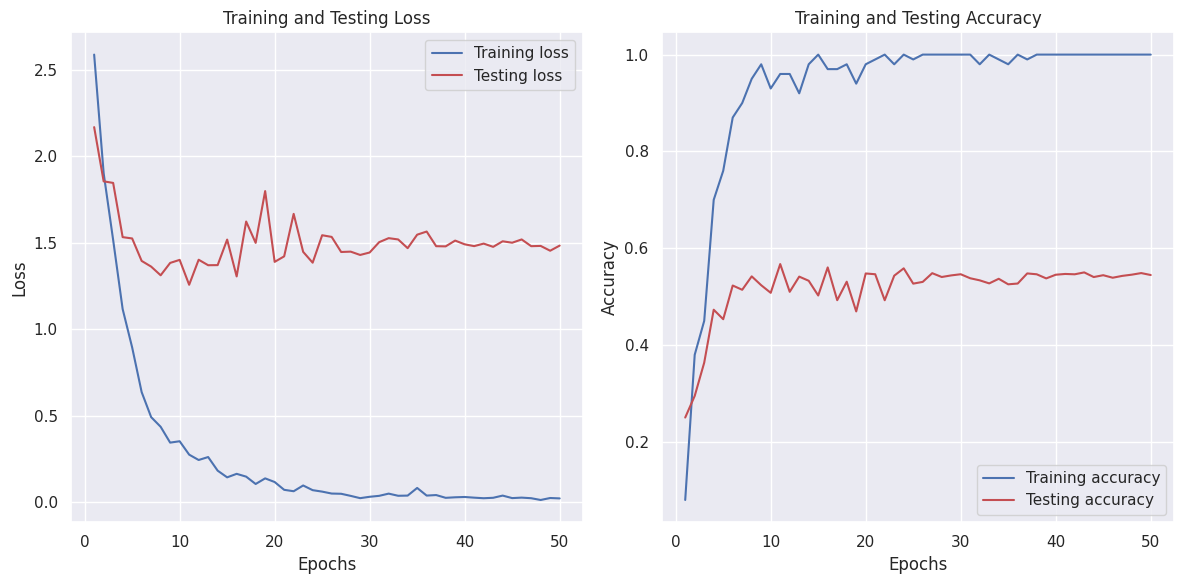

In [49]:
plot_metrics(losses, losses_test, accuracies, accuracies_test)

#### $\textbf{Experience 4}$: Training for 50 epochs, training all the layers and Resizing the images.

In [50]:
### resize the images 

transformations = transforms.Compose([transforms.Resize((224,224), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=MEAN, std=STD_DEV)])

train_dataloader = get_dataloader('training', transformations=transformations)
base_dataloader = get_dataloader('base', transformations=transformations)
test_dataloader = get_dataloader('testing', transformations=transformations)


model = torchvision.models.resnet18(weights='IMAGENET1K_V1').to(device)
# adapt it to cifar
# freeze_weights(model)

model.fc = nn.Sequential(
    nn.Linear(512,256),
    nn.Linear(256,10)
)

### ensure the last layer is not freezed 

for layer in model.fc:
    for param in layer.parameters():
        param.requires_grad = True

model.to(device)

lr = 0.001
max_epochs = 50

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor=.5, patience = 10, min_lr = 1e-7)
criterion = torch.nn.CrossEntropyLoss()
losses, accuracies, losses_test, accuracies_test = train(model, train_dataloader, test_dataloader, criterion, optimizer, device, epochs=max_epochs, scheduler=scheduler)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 0/49


100%|██████████| 1000/1000 [00:08<00:00, 111.36it/s]


Loss: 9.2079 Acc: 0.1423
Finised epoch 0/49, loss: 2.1001, acc: 0.3100
Test metrics 0/49, loss: 9.2079, acc: 0.1423
Epoch 1/49


100%|██████████| 1000/1000 [00:08<00:00, 112.06it/s]


Loss: 12.9114 Acc: 0.1313
Finised epoch 1/49, loss: 1.6435, acc: 0.4700
Test metrics 1/49, loss: 12.9114, acc: 0.1313
Epoch 2/49


100%|██████████| 1000/1000 [00:08<00:00, 111.97it/s]


Loss: 5.8750 Acc: 0.1720
Finised epoch 2/49, loss: 0.9800, acc: 0.6700
Test metrics 2/49, loss: 5.8750, acc: 0.1720
Epoch 3/49


100%|██████████| 1000/1000 [00:09<00:00, 111.03it/s]


Loss: 2.7835 Acc: 0.2744
Finised epoch 3/49, loss: 0.9782, acc: 0.6900
Test metrics 3/49, loss: 2.7835, acc: 0.2744
Epoch 4/49


100%|██████████| 1000/1000 [00:09<00:00, 110.58it/s]


Loss: 3.0359 Acc: 0.3112
Finised epoch 4/49, loss: 0.5270, acc: 0.8200
Test metrics 4/49, loss: 3.0359, acc: 0.3112
Epoch 5/49


100%|██████████| 1000/1000 [00:09<00:00, 110.88it/s]


Loss: 2.7126 Acc: 0.3405
Finised epoch 5/49, loss: 0.7093, acc: 0.8300
Test metrics 5/49, loss: 2.7126, acc: 0.3405
Epoch 6/49


100%|██████████| 1000/1000 [00:08<00:00, 111.21it/s]


Loss: 2.8139 Acc: 0.3069
Finised epoch 6/49, loss: 0.5595, acc: 0.8400
Test metrics 6/49, loss: 2.8139, acc: 0.3069
Epoch 7/49


100%|██████████| 1000/1000 [00:09<00:00, 110.94it/s]


Loss: 2.9993 Acc: 0.3018
Finised epoch 7/49, loss: 0.5718, acc: 0.8200
Test metrics 7/49, loss: 2.9993, acc: 0.3018
Epoch 8/49


100%|██████████| 1000/1000 [00:08<00:00, 111.16it/s]


Loss: 3.1882 Acc: 0.2547
Finised epoch 8/49, loss: 0.3716, acc: 0.8500
Test metrics 8/49, loss: 3.1882, acc: 0.2547
Epoch 9/49


100%|██████████| 1000/1000 [00:09<00:00, 110.62it/s]


Loss: 3.3205 Acc: 0.2733
Finised epoch 9/49, loss: 0.2672, acc: 0.9100
Test metrics 9/49, loss: 3.3205, acc: 0.2733
Epoch 10/49


100%|██████████| 1000/1000 [00:09<00:00, 110.38it/s]


Loss: 3.4806 Acc: 0.2612
Finised epoch 10/49, loss: 0.2068, acc: 0.9100
Test metrics 10/49, loss: 3.4806, acc: 0.2612
Epoch 11/49


100%|██████████| 1000/1000 [00:08<00:00, 111.20it/s]


Loss: 3.6270 Acc: 0.2898
Finised epoch 11/49, loss: 0.3229, acc: 0.9100
Test metrics 11/49, loss: 3.6270, acc: 0.2898
Epoch 12/49


100%|██████████| 1000/1000 [00:09<00:00, 110.18it/s]


Loss: 3.0722 Acc: 0.3444
Finised epoch 12/49, loss: 0.3016, acc: 0.9300
Test metrics 12/49, loss: 3.0722, acc: 0.3444
Epoch 13/49


100%|██████████| 1000/1000 [00:09<00:00, 110.35it/s]


Loss: 3.5782 Acc: 0.2831
Finised epoch 13/49, loss: 0.3197, acc: 0.9000
Test metrics 13/49, loss: 3.5782, acc: 0.2831
Epoch 14/49


100%|██████████| 1000/1000 [00:09<00:00, 109.62it/s]


Loss: 3.6110 Acc: 0.2808
Finised epoch 14/49, loss: 0.3639, acc: 0.8700
Test metrics 14/49, loss: 3.6110, acc: 0.2808
Epoch 15/49


100%|██████████| 1000/1000 [00:09<00:00, 109.85it/s]


Loss: 2.8687 Acc: 0.3119
Finised epoch 15/49, loss: 0.2914, acc: 0.9300
Test metrics 15/49, loss: 2.8687, acc: 0.3119
Epoch 16/49


100%|██████████| 1000/1000 [00:09<00:00, 110.12it/s]


Loss: 2.4716 Acc: 0.3579
Finised epoch 16/49, loss: 0.1987, acc: 0.9600
Test metrics 16/49, loss: 2.4716, acc: 0.3579
Epoch 17/49


100%|██████████| 1000/1000 [00:09<00:00, 110.15it/s]


Loss: 3.0859 Acc: 0.3391
Finised epoch 17/49, loss: 0.1705, acc: 0.9500
Test metrics 17/49, loss: 3.0859, acc: 0.3391
Epoch 18/49


100%|██████████| 1000/1000 [00:09<00:00, 109.81it/s]


Loss: 3.4631 Acc: 0.3166
Finised epoch 18/49, loss: 0.1558, acc: 0.9400
Test metrics 18/49, loss: 3.4631, acc: 0.3166
Epoch 19/49


100%|██████████| 1000/1000 [00:09<00:00, 109.74it/s]


Loss: 3.1237 Acc: 0.2932
Finised epoch 19/49, loss: 0.0893, acc: 0.9700
Test metrics 19/49, loss: 3.1237, acc: 0.2932
Epoch 20/49


100%|██████████| 1000/1000 [00:09<00:00, 110.60it/s]


Loss: 3.2237 Acc: 0.3358
Finised epoch 20/49, loss: 0.1514, acc: 0.9400
Test metrics 20/49, loss: 3.2237, acc: 0.3358
Epoch 21/49


100%|██████████| 1000/1000 [00:09<00:00, 111.08it/s]


Loss: 2.6840 Acc: 0.3618
Finised epoch 21/49, loss: 0.1906, acc: 0.9400
Test metrics 21/49, loss: 2.6840, acc: 0.3618
Epoch 22/49


100%|██████████| 1000/1000 [00:09<00:00, 110.34it/s]


Loss: 2.6598 Acc: 0.3523
Finised epoch 22/49, loss: 0.1488, acc: 0.9600
Test metrics 22/49, loss: 2.6598, acc: 0.3523
Epoch 23/49


100%|██████████| 1000/1000 [00:09<00:00, 110.17it/s]


Loss: 2.8906 Acc: 0.3240
Finised epoch 23/49, loss: 0.1516, acc: 0.9400
Test metrics 23/49, loss: 2.8906, acc: 0.3240
Epoch 24/49


100%|██████████| 1000/1000 [00:09<00:00, 109.73it/s]


Loss: 3.6023 Acc: 0.2634
Finised epoch 24/49, loss: 0.2629, acc: 0.9400
Test metrics 24/49, loss: 3.6023, acc: 0.2634
Epoch 25/49


100%|██████████| 1000/1000 [00:09<00:00, 110.23it/s]


Loss: 3.5394 Acc: 0.2963
Finised epoch 25/49, loss: 0.3884, acc: 0.8700
Test metrics 25/49, loss: 3.5394, acc: 0.2963
Epoch 26/49


100%|██████████| 1000/1000 [00:09<00:00, 110.91it/s]


Loss: 3.1200 Acc: 0.3059
Finised epoch 26/49, loss: 0.2218, acc: 0.9400
Test metrics 26/49, loss: 3.1200, acc: 0.3059
Epoch 27/49


100%|██████████| 1000/1000 [00:09<00:00, 110.48it/s]


Loss: 3.9125 Acc: 0.2873
Finised epoch 27/49, loss: 0.2129, acc: 0.9200
Test metrics 27/49, loss: 3.9125, acc: 0.2873
Epoch 28/49


100%|██████████| 1000/1000 [00:09<00:00, 110.04it/s]


Loss: 4.0297 Acc: 0.3010
Finised epoch 28/49, loss: 0.1074, acc: 0.9600
Test metrics 28/49, loss: 4.0297, acc: 0.3010
Epoch 29/49


100%|██████████| 1000/1000 [00:09<00:00, 110.55it/s]


Loss: 3.2375 Acc: 0.3261
Finised epoch 29/49, loss: 0.0795, acc: 0.9800
Test metrics 29/49, loss: 3.2375, acc: 0.3261
Epoch 30/49


100%|██████████| 1000/1000 [00:09<00:00, 110.66it/s]


Loss: 2.9072 Acc: 0.3305
Finised epoch 30/49, loss: 0.0638, acc: 0.9900
Test metrics 30/49, loss: 2.9072, acc: 0.3305
Epoch 31/49


100%|██████████| 1000/1000 [00:08<00:00, 111.29it/s]


Loss: 2.8365 Acc: 0.3507
Finised epoch 31/49, loss: 0.0703, acc: 0.9600
Test metrics 31/49, loss: 2.8365, acc: 0.3507
Epoch 32/49


100%|██████████| 1000/1000 [00:09<00:00, 111.03it/s]


Loss: 3.2792 Acc: 0.3176
Finised epoch 32/49, loss: 0.0791, acc: 0.9800
Test metrics 32/49, loss: 3.2792, acc: 0.3176
Epoch 33/49


100%|██████████| 1000/1000 [00:09<00:00, 110.35it/s]


Loss: 3.2121 Acc: 0.3332
Finised epoch 33/49, loss: 0.0768, acc: 0.9800
Test metrics 33/49, loss: 3.2121, acc: 0.3332
Epoch 34/49


100%|██████████| 1000/1000 [00:09<00:00, 110.69it/s]


Loss: 3.0985 Acc: 0.3481
Finised epoch 34/49, loss: 0.0188, acc: 1.0000
Test metrics 34/49, loss: 3.0985, acc: 0.3481
Epoch 35/49


100%|██████████| 1000/1000 [00:09<00:00, 109.70it/s]


Loss: 2.9148 Acc: 0.3687
Finised epoch 35/49, loss: 0.0347, acc: 0.9900
Test metrics 35/49, loss: 2.9148, acc: 0.3687
Epoch 36/49


100%|██████████| 1000/1000 [00:09<00:00, 110.80it/s]


Loss: 2.7502 Acc: 0.3682
Finised epoch 36/49, loss: 0.0357, acc: 0.9800
Test metrics 36/49, loss: 2.7502, acc: 0.3682
Epoch 37/49


100%|██████████| 1000/1000 [00:09<00:00, 109.64it/s]


Loss: 2.7600 Acc: 0.3657
Finised epoch 37/49, loss: 0.0031, acc: 1.0000
Test metrics 37/49, loss: 2.7600, acc: 0.3657
Epoch 38/49


100%|██████████| 1000/1000 [00:09<00:00, 110.00it/s]


Loss: 2.8399 Acc: 0.3601
Finised epoch 38/49, loss: 0.0032, acc: 1.0000
Test metrics 38/49, loss: 2.8399, acc: 0.3601
Epoch 39/49


100%|██████████| 1000/1000 [00:09<00:00, 110.00it/s]


Loss: 2.6987 Acc: 0.3719
Finised epoch 39/49, loss: 0.0094, acc: 1.0000
Test metrics 39/49, loss: 2.6987, acc: 0.3719
Epoch 40/49


100%|██████████| 1000/1000 [00:09<00:00, 109.78it/s]


Loss: 2.6940 Acc: 0.3712
Finised epoch 40/49, loss: 0.0010, acc: 1.0000
Test metrics 40/49, loss: 2.6940, acc: 0.3712
Epoch 41/49


100%|██████████| 1000/1000 [00:09<00:00, 110.55it/s]


Loss: 2.7317 Acc: 0.3729
Finised epoch 41/49, loss: 0.0087, acc: 1.0000
Test metrics 41/49, loss: 2.7317, acc: 0.3729
Epoch 42/49


100%|██████████| 1000/1000 [00:09<00:00, 110.39it/s]


Loss: 2.7840 Acc: 0.3771
Finised epoch 42/49, loss: 0.0045, acc: 1.0000
Test metrics 42/49, loss: 2.7840, acc: 0.3771
Epoch 43/49


100%|██████████| 1000/1000 [00:09<00:00, 109.86it/s]


Loss: 2.7917 Acc: 0.3799
Finised epoch 43/49, loss: 0.0159, acc: 1.0000
Test metrics 43/49, loss: 2.7917, acc: 0.3799
Epoch 44/49


100%|██████████| 1000/1000 [00:09<00:00, 108.69it/s]


Loss: 2.7218 Acc: 0.3776
Finised epoch 44/49, loss: 0.0013, acc: 1.0000
Test metrics 44/49, loss: 2.7218, acc: 0.3776
Epoch 45/49


100%|██████████| 1000/1000 [00:09<00:00, 109.29it/s]


Loss: 2.6856 Acc: 0.3795
Finised epoch 45/49, loss: 0.0043, acc: 1.0000
Test metrics 45/49, loss: 2.6856, acc: 0.3795
Epoch 46/49


100%|██████████| 1000/1000 [00:09<00:00, 110.31it/s]


Loss: 2.7205 Acc: 0.3789
Finised epoch 46/49, loss: 0.0021, acc: 1.0000
Test metrics 46/49, loss: 2.7205, acc: 0.3789
Epoch 47/49


100%|██████████| 1000/1000 [00:08<00:00, 112.13it/s]


Loss: 2.6811 Acc: 0.3828
Finised epoch 47/49, loss: 0.0016, acc: 1.0000
Test metrics 47/49, loss: 2.6811, acc: 0.3828
Epoch 48/49


100%|██████████| 1000/1000 [00:09<00:00, 108.85it/s]


Loss: 2.6858 Acc: 0.3843
Finised epoch 48/49, loss: 0.0021, acc: 1.0000
Test metrics 48/49, loss: 2.6858, acc: 0.3843
Epoch 49/49


100%|██████████| 1000/1000 [00:08<00:00, 111.37it/s]

Loss: 2.6489 Acc: 0.3931
Finised epoch 49/49, loss: 0.0021, acc: 1.0000
Test metrics 49/49, loss: 2.6489, acc: 0.3931
Finished Training


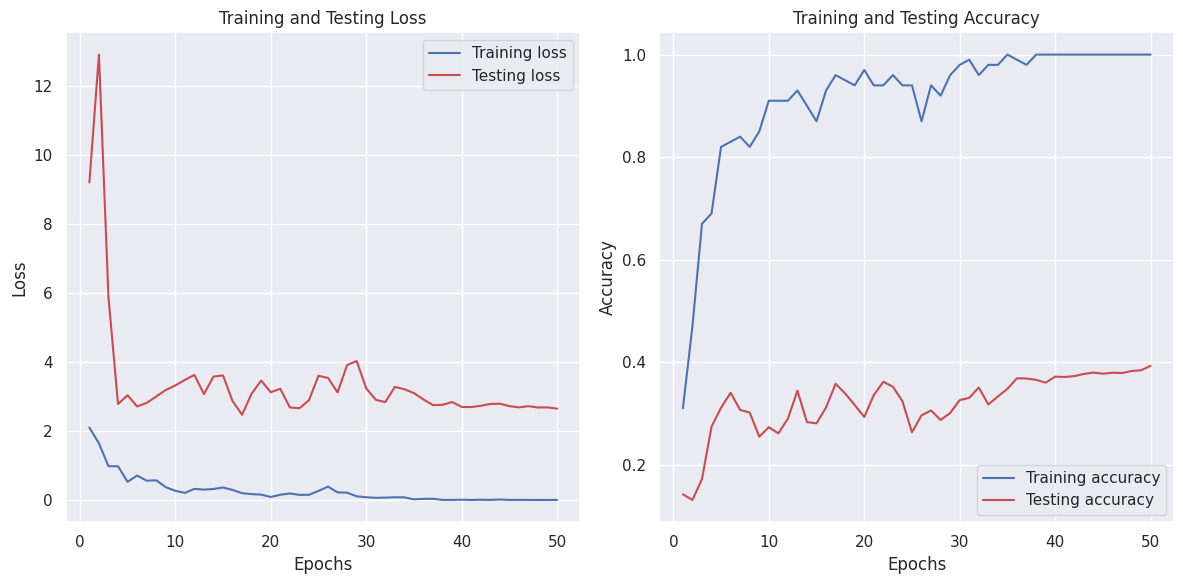

In [51]:
plot_metrics(losses, losses_test, accuracies, accuracies_test)

#### $\textbf{Results}$:

| Experience | Number of  epochs  | Train accuracy max/final | Test accuracy |
|------|------|------|------|
|   Freeze / No Resizing | 50 | $89\%$ | $24\%$ |
|  No Freeze / no Resizing  | 50 | $100\%$ | $32\%$ |
|  No Freeze / Resizing  | 50 | $100\%$ | $55\%$ |
|  Freeze / Resizing  | 30 | $100\%$  | $40\%$ |


We conclude that leveraging pretrained models can indeed improve the performance of the model. We can go up to $60\%$ accuracy on the testing set, only by training only the $100$ images in the dataset. 

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks, though one might have to handle several boundary effects.

__Question 5 (0.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

## Dealing with Image Transformations on 32x32 Images

### Translation (Moving the Image Around)
- **Problem:** Moving the image might cut off parts that go beyond the edges, leading to loss of some picture information.
- **Solution:** Use a wrapping technique where the parts moving off one edge reappear on the opposite edge, keeping all image information intact.

### Rotation (Turning the Image)
- **Problem:** Rotating causes some parts of the image not to align with the pixel grid, creating gaps or voids.
- **Solution:** Fill in these gaps by estimating colors, using techniques like linear, bilinear, or cubic interpolation.

### Scaling (Changing the Size)
- **Problem:** Enlarging an image can make it blurry, while shrinking can introduce jagged edges or weird patterns (aliasing).
- **Solution:** Employ interpolation for smooth resizing. Use anti-aliasing filters when reducing size and reconstruction filters for enlarging.

### Color Changes (Adjusting Colors)
- **Problem:** Adjusting colors can result in unnatural appearance due to the sensitive nature of color mixing in images.
- **Solution:** Switch to a color format like HSV (Hue, Saturation, Value) which separates color information from intensity, allowing for more natural adjustments to brightness or color.


## Data augmentations

__Question 6 (4 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

#### $\textbf{First experience}$

In [54]:
transformations = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomVerticalFlip(p=0.5),
                                 #transforms.RandomSolarize(0.5, p=0.5),
                                #  transforms.RandomRotation(20),
                                 transforms.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333)),
                                 transforms.GaussianBlur(kernel_size=(3,3)),
                                 transforms.ColorJitter(hue=.1),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=MEAN, std=STD_DEV)])

train_dataloader = get_dataloader('training', transformations=transformations)
base_dataloader = get_dataloader('base', transformations=transformations)
test_dataloader = get_dataloader('testing', transformations=transformations)

lr = 0.0001
max_epochs = 30

model = ResNet18().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=.01)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor=.5, patience = 10, min_lr = 1e-7)

criterion = torch.nn.CrossEntropyLoss()
losses, accuracies, losses_test, accuracies_test = train(model, train_dataloader, test_dataloader, criterion, optimizer, device, epochs=max_epochs, scheduler=scheduler)
# test_loss, test_acc = test(model, test_dataloader, criterion, device)

# plt.plot(losses, label='training loss')
# plt.show()
# print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 0/29


100%|██████████| 1000/1000 [00:11<00:00, 83.61it/s]


Loss: 2.3475 Acc: 0.1000
Finised epoch 0/29, loss: 2.4081, acc: 0.1400
Test metrics 0/29, loss: 2.3475, acc: 0.1000
Epoch 1/29


100%|██████████| 1000/1000 [00:12<00:00, 83.16it/s]


Loss: 2.7025 Acc: 0.1000
Finised epoch 1/29, loss: 2.0674, acc: 0.3000
Test metrics 1/29, loss: 2.7025, acc: 0.1000
Epoch 2/29


100%|██████████| 1000/1000 [00:11<00:00, 83.60it/s]


Loss: 2.7959 Acc: 0.1066
Finised epoch 2/29, loss: 1.8877, acc: 0.3300
Test metrics 2/29, loss: 2.7959, acc: 0.1066
Epoch 3/29


100%|██████████| 1000/1000 [00:12<00:00, 83.25it/s]


Loss: 2.5292 Acc: 0.1644
Finised epoch 3/29, loss: 1.7119, acc: 0.4400
Test metrics 3/29, loss: 2.5292, acc: 0.1644
Epoch 4/29


100%|██████████| 1000/1000 [00:11<00:00, 83.34it/s]


Loss: 2.6741 Acc: 0.1930
Finised epoch 4/29, loss: 1.6514, acc: 0.4400
Test metrics 4/29, loss: 2.6741, acc: 0.1930
Epoch 5/29


100%|██████████| 1000/1000 [00:11<00:00, 83.45it/s]


Loss: 2.8274 Acc: 0.1852
Finised epoch 5/29, loss: 1.5190, acc: 0.5200
Test metrics 5/29, loss: 2.8274, acc: 0.1852
Epoch 6/29


100%|██████████| 1000/1000 [00:12<00:00, 83.12it/s]


Loss: 2.6078 Acc: 0.1940
Finised epoch 6/29, loss: 1.4759, acc: 0.4500
Test metrics 6/29, loss: 2.6078, acc: 0.1940
Epoch 7/29


100%|██████████| 1000/1000 [00:12<00:00, 82.94it/s]


Loss: 2.9384 Acc: 0.2102
Finised epoch 7/29, loss: 1.1855, acc: 0.5800
Test metrics 7/29, loss: 2.9384, acc: 0.2102
Epoch 8/29


100%|██████████| 1000/1000 [00:12<00:00, 83.02it/s]


Loss: 3.2536 Acc: 0.1887
Finised epoch 8/29, loss: 1.3083, acc: 0.5400
Test metrics 8/29, loss: 3.2536, acc: 0.1887
Epoch 9/29


100%|██████████| 1000/1000 [00:12<00:00, 83.05it/s]


Loss: 3.0124 Acc: 0.1965
Finised epoch 9/29, loss: 1.0906, acc: 0.6400
Test metrics 9/29, loss: 3.0124, acc: 0.1965
Epoch 10/29


100%|██████████| 1000/1000 [00:12<00:00, 83.01it/s]


Loss: 3.3413 Acc: 0.1963
Finised epoch 10/29, loss: 1.1356, acc: 0.5900
Test metrics 10/29, loss: 3.3413, acc: 0.1963
Epoch 11/29


100%|██████████| 1000/1000 [00:11<00:00, 83.47it/s]


Loss: 3.4364 Acc: 0.2006
Finised epoch 11/29, loss: 1.1027, acc: 0.6600
Test metrics 11/29, loss: 3.4364, acc: 0.2006
Epoch 12/29


100%|██████████| 1000/1000 [00:12<00:00, 83.33it/s]


Loss: 3.2010 Acc: 0.1880
Finised epoch 12/29, loss: 0.9072, acc: 0.7200
Test metrics 12/29, loss: 3.2010, acc: 0.1880
Epoch 13/29


100%|██████████| 1000/1000 [00:11<00:00, 83.39it/s]


Loss: 3.1831 Acc: 0.2030
Finised epoch 13/29, loss: 0.9214, acc: 0.7100
Test metrics 13/29, loss: 3.1831, acc: 0.2030
Epoch 14/29


100%|██████████| 1000/1000 [00:11<00:00, 83.56it/s]


Loss: 3.1363 Acc: 0.1958
Finised epoch 14/29, loss: 0.9761, acc: 0.6900
Test metrics 14/29, loss: 3.1363, acc: 0.1958
Epoch 15/29


100%|██████████| 1000/1000 [00:11<00:00, 83.52it/s]


Loss: 3.5136 Acc: 0.1816
Finised epoch 15/29, loss: 0.5894, acc: 0.8200
Test metrics 15/29, loss: 3.5136, acc: 0.1816
Epoch 16/29


100%|██████████| 1000/1000 [00:11<00:00, 83.47it/s]


Loss: 3.5360 Acc: 0.2000
Finised epoch 16/29, loss: 0.8017, acc: 0.7300
Test metrics 16/29, loss: 3.5360, acc: 0.2000
Epoch 17/29


100%|██████████| 1000/1000 [00:11<00:00, 83.48it/s]


Loss: 3.2791 Acc: 0.2103
Finised epoch 17/29, loss: 0.7059, acc: 0.8000
Test metrics 17/29, loss: 3.2791, acc: 0.2103
Epoch 18/29


100%|██████████| 1000/1000 [00:11<00:00, 83.46it/s]


Loss: 3.4646 Acc: 0.2220
Finised epoch 18/29, loss: 0.5789, acc: 0.8000
Test metrics 18/29, loss: 3.4646, acc: 0.2220
Epoch 19/29


100%|██████████| 1000/1000 [00:11<00:00, 83.53it/s]


Loss: 3.9961 Acc: 0.1903
Finised epoch 19/29, loss: 0.8382, acc: 0.7000
Test metrics 19/29, loss: 3.9961, acc: 0.1903
Epoch 20/29


100%|██████████| 1000/1000 [00:11<00:00, 83.40it/s]


Loss: 3.8208 Acc: 0.2245
Finised epoch 20/29, loss: 0.8186, acc: 0.7400
Test metrics 20/29, loss: 3.8208, acc: 0.2245
Epoch 21/29


100%|██████████| 1000/1000 [00:12<00:00, 83.26it/s]


Loss: 3.8537 Acc: 0.1994
Finised epoch 21/29, loss: 0.7949, acc: 0.7300
Test metrics 21/29, loss: 3.8537, acc: 0.1994
Epoch 22/29


100%|██████████| 1000/1000 [00:12<00:00, 83.27it/s]


Loss: 3.3002 Acc: 0.2135
Finised epoch 22/29, loss: 0.6659, acc: 0.7600
Test metrics 22/29, loss: 3.3002, acc: 0.2135
Epoch 23/29


100%|██████████| 1000/1000 [00:11<00:00, 83.49it/s]


Loss: 3.4766 Acc: 0.2175
Finised epoch 23/29, loss: 0.5692, acc: 0.8200
Test metrics 23/29, loss: 3.4766, acc: 0.2175
Epoch 24/29


100%|██████████| 1000/1000 [00:11<00:00, 83.43it/s]


Loss: 3.4107 Acc: 0.2230
Finised epoch 24/29, loss: 0.3858, acc: 0.9000
Test metrics 24/29, loss: 3.4107, acc: 0.2230
Epoch 25/29


100%|██████████| 1000/1000 [00:11<00:00, 83.34it/s]


Loss: 3.4024 Acc: 0.2263
Finised epoch 25/29, loss: 0.5518, acc: 0.8500
Test metrics 25/29, loss: 3.4024, acc: 0.2263
Epoch 26/29


100%|██████████| 1000/1000 [00:11<00:00, 83.38it/s]


Loss: 3.7851 Acc: 0.2011
Finised epoch 26/29, loss: 0.6589, acc: 0.7800
Test metrics 26/29, loss: 3.7851, acc: 0.2011
Epoch 27/29


100%|██████████| 1000/1000 [00:11<00:00, 83.39it/s]


Loss: 3.3331 Acc: 0.2298
Finised epoch 27/29, loss: 0.5018, acc: 0.8300
Test metrics 27/29, loss: 3.3331, acc: 0.2298
Epoch 28/29


100%|██████████| 1000/1000 [00:12<00:00, 83.24it/s]


Loss: 3.3690 Acc: 0.2122
Finised epoch 28/29, loss: 0.5729, acc: 0.7900
Test metrics 28/29, loss: 3.3690, acc: 0.2122
Epoch 29/29


100%|██████████| 1000/1000 [00:11<00:00, 83.52it/s]

Loss: 3.5614 Acc: 0.1953
Finised epoch 29/29, loss: 0.3714, acc: 0.9000
Test metrics 29/29, loss: 3.5614, acc: 0.1953
Finished Training


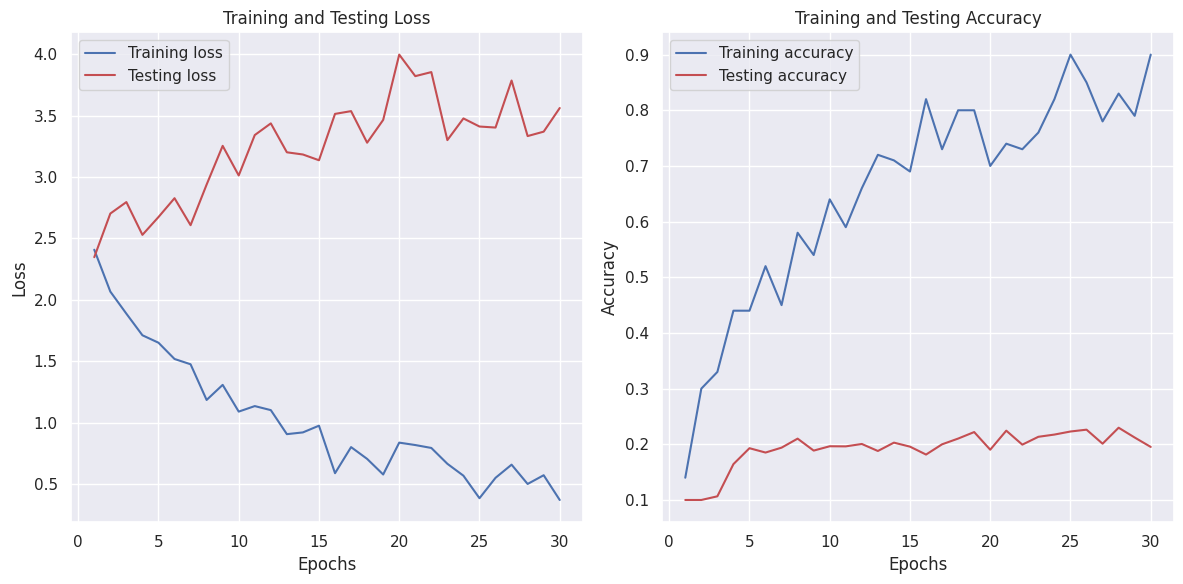

In [55]:
plot_metrics(losses, losses_test, accuracies, accuracies_test)


#### $\textbf{With less augmentation}$

In [56]:
transformations = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                #  transforms.RandomVerticalFlip(p=0.5),
                                 #transforms.RandomSolarize(0.5, p=0.5),
                                 transforms.RandomRotation(10),
                                 transforms.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333)),
                                 transforms.GaussianBlur(kernel_size=(3,3)),
                                 transforms.ColorJitter(hue=.05),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=MEAN, std=STD_DEV)])

train_dataloader = get_dataloader('training', transformations=transformations)
base_dataloader = get_dataloader('base', transformations=transformations)
test_dataloader = get_dataloader('testing', transformations=transformations)

lr = 0.0001
max_epochs = 30

model = ResNet18().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=.01)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor=.5, patience = 10, min_lr = 1e-7)

criterion = torch.nn.CrossEntropyLoss()
losses, accuracies, losses_test, accuracies_test = train(model, train_dataloader, test_dataloader, criterion, optimizer, device, epochs=max_epochs, scheduler=scheduler)
# test_loss, test_acc = test(model, test_dataloader, criterion, device)

# plt.plot(losses, label='training loss')
# plt.show()
# print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 0/29


100%|██████████| 1000/1000 [00:12<00:00, 80.92it/s]


Loss: 2.3874 Acc: 0.1000
Finised epoch 0/29, loss: 2.3845, acc: 0.2100
Test metrics 0/29, loss: 2.3874, acc: 0.1000
Epoch 1/29


100%|██████████| 1000/1000 [00:12<00:00, 81.34it/s]


Loss: 2.5554 Acc: 0.1000
Finised epoch 1/29, loss: 2.0168, acc: 0.2800
Test metrics 1/29, loss: 2.5554, acc: 0.1000
Epoch 2/29


100%|██████████| 1000/1000 [00:12<00:00, 81.24it/s]


Loss: 2.7191 Acc: 0.1199
Finised epoch 2/29, loss: 1.7183, acc: 0.4800
Test metrics 2/29, loss: 2.7191, acc: 0.1199
Epoch 3/29


100%|██████████| 1000/1000 [00:12<00:00, 81.67it/s]


Loss: 2.5829 Acc: 0.1643
Finised epoch 3/29, loss: 1.4516, acc: 0.4900
Test metrics 3/29, loss: 2.5829, acc: 0.1643
Epoch 4/29


100%|██████████| 1000/1000 [00:12<00:00, 81.51it/s]


Loss: 2.9142 Acc: 0.2086
Finised epoch 4/29, loss: 1.2185, acc: 0.5700
Test metrics 4/29, loss: 2.9142, acc: 0.2086
Epoch 5/29


100%|██████████| 1000/1000 [00:12<00:00, 81.35it/s]


Loss: 2.9691 Acc: 0.2263
Finised epoch 5/29, loss: 1.0791, acc: 0.6200
Test metrics 5/29, loss: 2.9691, acc: 0.2263
Epoch 6/29


100%|██████████| 1000/1000 [00:12<00:00, 81.27it/s]


Loss: 2.9331 Acc: 0.2166
Finised epoch 6/29, loss: 0.8138, acc: 0.7600
Test metrics 6/29, loss: 2.9331, acc: 0.2166
Epoch 7/29


100%|██████████| 1000/1000 [00:12<00:00, 81.22it/s]


Loss: 3.4355 Acc: 0.1950
Finised epoch 7/29, loss: 0.7456, acc: 0.7800
Test metrics 7/29, loss: 3.4355, acc: 0.1950
Epoch 8/29


100%|██████████| 1000/1000 [00:12<00:00, 81.22it/s]


Loss: 3.0057 Acc: 0.2414
Finised epoch 8/29, loss: 0.7464, acc: 0.7700
Test metrics 8/29, loss: 3.0057, acc: 0.2414
Epoch 9/29


100%|██████████| 1000/1000 [00:12<00:00, 81.05it/s]


Loss: 3.3591 Acc: 0.2025
Finised epoch 9/29, loss: 0.6754, acc: 0.7500
Test metrics 9/29, loss: 3.3591, acc: 0.2025
Epoch 10/29


100%|██████████| 1000/1000 [00:12<00:00, 81.01it/s]


Loss: 3.2247 Acc: 0.2090
Finised epoch 10/29, loss: 0.6448, acc: 0.8100
Test metrics 10/29, loss: 3.2247, acc: 0.2090
Epoch 11/29


100%|██████████| 1000/1000 [00:12<00:00, 79.50it/s]


Loss: 3.2210 Acc: 0.2392
Finised epoch 11/29, loss: 0.5151, acc: 0.8500
Test metrics 11/29, loss: 3.2210, acc: 0.2392
Epoch 12/29


100%|██████████| 1000/1000 [00:12<00:00, 78.63it/s]


Loss: 3.8003 Acc: 0.2158
Finised epoch 12/29, loss: 0.5573, acc: 0.8600
Test metrics 12/29, loss: 3.8003, acc: 0.2158
Epoch 13/29


100%|██████████| 1000/1000 [00:12<00:00, 77.93it/s]


Loss: 3.5790 Acc: 0.2249
Finised epoch 13/29, loss: 0.5628, acc: 0.8100
Test metrics 13/29, loss: 3.5790, acc: 0.2249
Epoch 14/29


100%|██████████| 1000/1000 [00:12<00:00, 77.75it/s]


Loss: 3.6452 Acc: 0.2512
Finised epoch 14/29, loss: 0.5719, acc: 0.8700
Test metrics 14/29, loss: 3.6452, acc: 0.2512
Epoch 15/29


100%|██████████| 1000/1000 [00:12<00:00, 77.79it/s]


Loss: 3.2989 Acc: 0.2473
Finised epoch 15/29, loss: 0.5027, acc: 0.8100
Test metrics 15/29, loss: 3.2989, acc: 0.2473
Epoch 16/29


100%|██████████| 1000/1000 [00:12<00:00, 77.76it/s]


Loss: 3.2515 Acc: 0.2264
Finised epoch 16/29, loss: 0.4196, acc: 0.8700
Test metrics 16/29, loss: 3.2515, acc: 0.2264
Epoch 17/29


100%|██████████| 1000/1000 [00:12<00:00, 78.73it/s]


Loss: 3.2970 Acc: 0.2214
Finised epoch 17/29, loss: 0.4001, acc: 0.9000
Test metrics 17/29, loss: 3.2970, acc: 0.2214
Epoch 18/29


100%|██████████| 1000/1000 [00:12<00:00, 77.86it/s]


Loss: 3.4305 Acc: 0.2137
Finised epoch 18/29, loss: 0.3610, acc: 0.8500
Test metrics 18/29, loss: 3.4305, acc: 0.2137
Epoch 19/29


100%|██████████| 1000/1000 [00:12<00:00, 77.92it/s]


Loss: 3.3389 Acc: 0.2225
Finised epoch 19/29, loss: 0.2939, acc: 0.9000
Test metrics 19/29, loss: 3.3389, acc: 0.2225
Epoch 20/29


100%|██████████| 1000/1000 [00:12<00:00, 77.92it/s]


Loss: 3.3703 Acc: 0.2350
Finised epoch 20/29, loss: 0.1714, acc: 0.9900
Test metrics 20/29, loss: 3.3703, acc: 0.2350
Epoch 21/29


100%|██████████| 1000/1000 [00:12<00:00, 77.80it/s]


Loss: 3.3571 Acc: 0.2370
Finised epoch 21/29, loss: 0.3707, acc: 0.9000
Test metrics 21/29, loss: 3.3571, acc: 0.2370
Epoch 22/29


100%|██████████| 1000/1000 [00:12<00:00, 77.86it/s]


Loss: 3.6731 Acc: 0.2311
Finised epoch 22/29, loss: 0.3196, acc: 0.9200
Test metrics 22/29, loss: 3.6731, acc: 0.2311
Epoch 23/29


100%|██████████| 1000/1000 [00:12<00:00, 80.48it/s]


Loss: 3.3419 Acc: 0.2461
Finised epoch 23/29, loss: 0.2770, acc: 0.9200
Test metrics 23/29, loss: 3.3419, acc: 0.2461
Epoch 24/29


100%|██████████| 1000/1000 [00:12<00:00, 78.99it/s]


Loss: 3.5705 Acc: 0.2265
Finised epoch 24/29, loss: 0.1902, acc: 0.9500
Test metrics 24/29, loss: 3.5705, acc: 0.2265
Epoch 25/29


100%|██████████| 1000/1000 [00:12<00:00, 78.85it/s]


Loss: 3.6223 Acc: 0.2405
Finised epoch 25/29, loss: 0.2046, acc: 0.9300
Test metrics 25/29, loss: 3.6223, acc: 0.2405
Epoch 26/29


100%|██████████| 1000/1000 [00:12<00:00, 78.71it/s]


Loss: 3.3901 Acc: 0.2488
Finised epoch 26/29, loss: 0.1797, acc: 0.9700
Test metrics 26/29, loss: 3.3901, acc: 0.2488
Epoch 27/29


100%|██████████| 1000/1000 [00:12<00:00, 78.84it/s]


Loss: 3.2398 Acc: 0.2566
Finised epoch 27/29, loss: 0.1601, acc: 0.9700
Test metrics 27/29, loss: 3.2398, acc: 0.2566
Epoch 28/29


100%|██████████| 1000/1000 [00:12<00:00, 77.66it/s]


Loss: 3.2794 Acc: 0.2539
Finised epoch 28/29, loss: 0.1345, acc: 0.9700
Test metrics 28/29, loss: 3.2794, acc: 0.2539
Epoch 29/29


100%|██████████| 1000/1000 [00:12<00:00, 77.90it/s]

Loss: 3.3129 Acc: 0.2508
Finised epoch 29/29, loss: 0.1727, acc: 0.9600
Test metrics 29/29, loss: 3.3129, acc: 0.2508
Finished Training


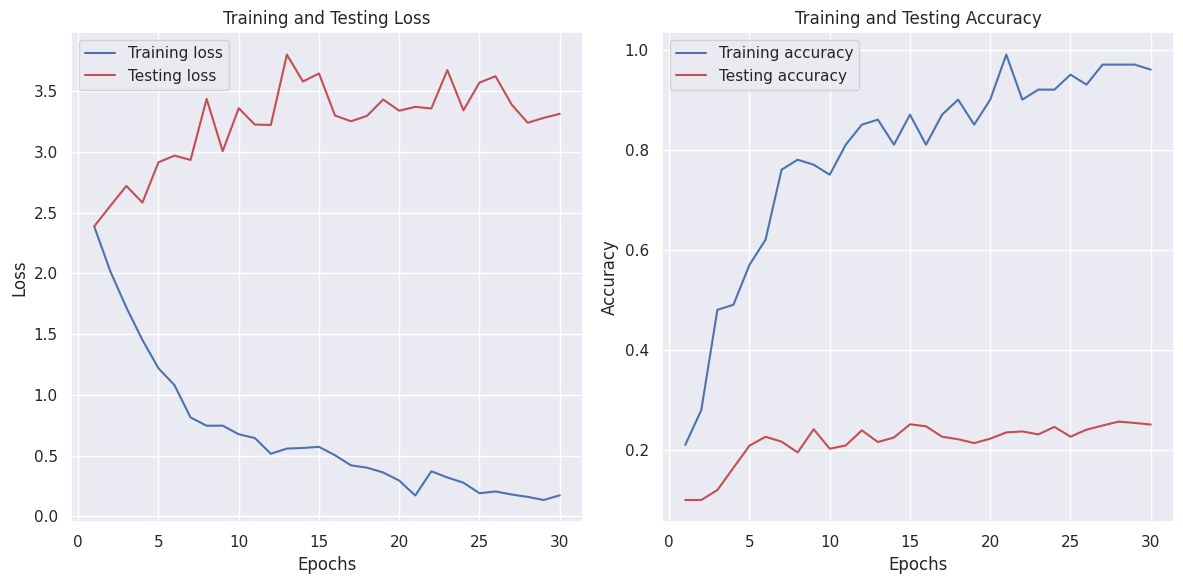

In [58]:
plot_metrics(losses, losses_test, accuracies, accuracies_test)

#### $\textbf{Results:}$

| Experience | Number of  epochs  | Train accuracy max/final | Test accuracy max/final|
|------|------|------|------|
|   Data augmentation | 30 | $90\%$ | $26\%$ / $25\%$ |

# Conclusions

__Question 7 (3 points) :__ Write a short report explaining the pros and the cons of each method that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

$\textbf{Context}$: In this notebook, we focus on the performance of a model trained on a small subset of the training set. Specifically, we used only 100 images and classified 10 classes. The baseline we leveraged achieved a performance of $23%$ on average across the final epochs, which is low compared to the usual accuracy obtained when training on the full dataset.

$\textbf{Transfer learning}$: The first approach we consider to increase performance is to leverage transfer learning. More particularly, we used CNNs pretrained on the ImageNet dataset and observed the change in performance. We observed that we significantly improved our performance. Training all the weights yields the best results, but it is computationally expensive. We only did 30 epochs, although we could further increase the results. However, even training only the last linear layers allows us to greatly improve performance, from $23%$ to $55%$, still using only 100 images from the original dataset.

$\textbf{Data augmentation}$: Although data augmentation reduced the training accuracy, allowing us to counter overfitting of the model, we still did not observe significant improvements in performance compared to the baseline when leveraging many augmentations. Therefore, leveraging data augmentation seems challenging to increase results in our case. We did a second experiments where we did not use as many data augmentation and we indeed observed an increased in performence. We achieved to increase by at least $2\%$ our results.

$\textbf{Weakly Supervised pretraining}$: The rotation prediction pretraining revealed itself to be quite efficient. After pretraining it for only 21 epochs, we perform a finetuning procedure. We find that this method was particularly efficient, both in term of results and in term of compute. Finetuning the whole model delivered great results ($42\%$ of test accuracy), and even finetuning only the last layer led good results ($32\%$ of test accuracy). This method is particularly appealing as we only used the images from the dataset, and only 100 labeled data.

# Weak supervision

__Bonus \[open\] question (up to 3 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

We try to pretrain our model using the method from the paper [Unsupervised Representation Learning by Predicting Image Rotations](https://arxiv.org/abs/1803.07728) methodology. The idea is to apply one of 4 rotation transformations (either none, 90°, 180° or 270°) on the images, and the model has to classify it in one of 4 classes - one for each transformation. The intuition is that the model will be forced to learn semantic information about patterns, shapes and sizes to correctly predict the rotation.

The final layer of the model is then switched for a ```torch.nn.Linear(512, 10)```for the CIFAR-10 classification, and the model is finetuned on $\mathcal{X}_{train}$.

The final model yields an accuracy of 31%, which is pretty good considering that the pratraining was not very costly (compared to training from scratch on ImageNet for instance).

| Experience | Number of  epochs  | Train accuracy max/final | Test accuracy final|
|------|------|------|------|
|   Full finetuning | 21 + 15 | $100\%$ | $41.3\%$ |
|   Last layer finetuning | 21 + 50 | $70\%$ | $34\%$ |

We also experimented with doing a continuous regression of the rotation angle, but non square rotations lead to black pixels on the edges which in turn causes massive overfitting (after only one epoch). This gave us the idea to go for only vertical and horizontal flips.

In [5]:

max_epochs = 21
lr = 0.001

model = ResNet18()
model.linear = nn.Linear(512, 4)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = None
criterion = torch.nn.CrossEntropyLoss()
transformations = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=MEAN, std=STD_DEV)])
base_dataloader = get_dataloader('base', batch_size=128, transformations=transformations)
test_dataloader = get_dataloader('testing', batch_size=512, transformations=transformations)

losses = []
eval_losses = []
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for inputs, _ in tqdm(base_dataloader):
        angle = torch.randint(0, 4, (inputs.size(0),), dtype=torch.float32)
        for i in range(inputs.size(0)):
            inputs[i] = transforms.functional.rotate(inputs[i], angle=angle[i].item() * 90)
        inputs = inputs.to(device)
        labels = angle.to(device).long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    loss = running_loss / len(base_dataloader.dataset)
    print(f'Epoch {epoch}/{max_epochs - 1}, loss: {loss:.4f}')
    losses.append(loss)
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        for inputs, _ in tqdm(test_dataloader):
            angle = torch.randint(0, 4, (inputs.size(0),), dtype=torch.float32)
            for i in range(inputs.size(0)):
                inputs[i] = transforms.functional.rotate(inputs[i], angle=angle[i].item() * 90)
            inputs = inputs.to(device)
            labels = angle.to(device).long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
        loss = running_loss / len(test_dataloader.dataset)
        eval_losses.append(loss)
        print(f'Test {epoch}/{max_epochs - 1}, loss: {loss:.4f}')
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f'model_{epoch}.pth')

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/391 [00:00<?, ?it/s]/Data/jaybee/miniconda3/envs/altegrad/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 391/391 [00:23<00:00, 16.63it/s]


Epoch 0/20, loss: 1.0725


100%|██████████| 20/20 [00:03<00:00,  6.30it/s]


Test 0/20, loss: 0.9688


100%|██████████| 391/391 [00:23<00:00, 16.84it/s]


Epoch 1/20, loss: 0.8902


100%|██████████| 20/20 [00:03<00:00,  6.37it/s]


Test 1/20, loss: 0.8324


100%|██████████| 391/391 [00:23<00:00, 16.79it/s]


Epoch 2/20, loss: 0.7919


100%|██████████| 20/20 [00:03<00:00,  6.37it/s]


Test 2/20, loss: 0.8697


100%|██████████| 391/391 [00:23<00:00, 16.76it/s]


Epoch 3/20, loss: 0.7234


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


Test 3/20, loss: 0.7854


100%|██████████| 391/391 [00:23<00:00, 16.75it/s]


Epoch 4/20, loss: 0.6605


100%|██████████| 20/20 [00:03<00:00,  6.37it/s]


Test 4/20, loss: 0.6836


100%|██████████| 391/391 [00:23<00:00, 16.75it/s]


Epoch 5/20, loss: 0.6142


100%|██████████| 20/20 [00:03<00:00,  6.36it/s]


Test 5/20, loss: 0.6619


100%|██████████| 391/391 [00:23<00:00, 16.73it/s]


Epoch 6/20, loss: 0.5689


100%|██████████| 20/20 [00:03<00:00,  6.36it/s]


Test 6/20, loss: 0.6363


100%|██████████| 391/391 [00:23<00:00, 16.70it/s]


Epoch 7/20, loss: 0.5346


100%|██████████| 20/20 [00:03<00:00,  6.29it/s]


Test 7/20, loss: 0.6330


100%|██████████| 391/391 [00:23<00:00, 16.59it/s]


Epoch 8/20, loss: 0.5015


100%|██████████| 20/20 [00:03<00:00,  6.16it/s]


Test 8/20, loss: 0.5652


100%|██████████| 391/391 [00:23<00:00, 16.42it/s]


Epoch 9/20, loss: 0.4706


100%|██████████| 20/20 [00:03<00:00,  6.19it/s]


Test 9/20, loss: 0.4876


100%|██████████| 391/391 [00:23<00:00, 16.43it/s]


Epoch 10/20, loss: 0.4417


100%|██████████| 20/20 [00:03<00:00,  6.19it/s]


Test 10/20, loss: 0.5060


100%|██████████| 391/391 [00:23<00:00, 16.66it/s]


Epoch 11/20, loss: 0.4131


100%|██████████| 20/20 [00:03<00:00,  6.30it/s]


Test 11/20, loss: 0.4658


100%|██████████| 391/391 [00:23<00:00, 16.38it/s]


Epoch 12/20, loss: 0.3855


100%|██████████| 20/20 [00:03<00:00,  6.17it/s]


Test 12/20, loss: 0.5349


100%|██████████| 391/391 [00:23<00:00, 16.43it/s]


Epoch 13/20, loss: 0.3661


100%|██████████| 20/20 [00:03<00:00,  6.20it/s]


Test 13/20, loss: 0.4338


100%|██████████| 391/391 [00:23<00:00, 16.46it/s]


Epoch 14/20, loss: 0.3378


100%|██████████| 20/20 [00:03<00:00,  6.20it/s]


Test 14/20, loss: 0.4904


100%|██████████| 391/391 [00:23<00:00, 16.58it/s]


Epoch 15/20, loss: 0.3222


100%|██████████| 20/20 [00:03<00:00,  6.31it/s]


Test 15/20, loss: 0.5245


100%|██████████| 391/391 [00:23<00:00, 16.67it/s]


Epoch 16/20, loss: 0.2978


100%|██████████| 20/20 [00:03<00:00,  6.31it/s]


Test 16/20, loss: 0.4585


100%|██████████| 391/391 [00:23<00:00, 16.68it/s]


Epoch 17/20, loss: 0.2799


100%|██████████| 20/20 [00:03<00:00,  6.32it/s]


Test 17/20, loss: 0.4438


100%|██████████| 391/391 [00:23<00:00, 16.68it/s]


Epoch 18/20, loss: 0.2616


100%|██████████| 20/20 [00:03<00:00,  6.31it/s]


Test 18/20, loss: 0.4048


100%|██████████| 391/391 [00:23<00:00, 16.68it/s]


Epoch 19/20, loss: 0.2490


100%|██████████| 20/20 [00:03<00:00,  6.31it/s]


Test 19/20, loss: 0.4403


100%|██████████| 391/391 [00:23<00:00, 16.68it/s]


Epoch 20/20, loss: 0.2271


100%|██████████| 20/20 [00:03<00:00,  6.32it/s]

Test 20/20, loss: 0.4091


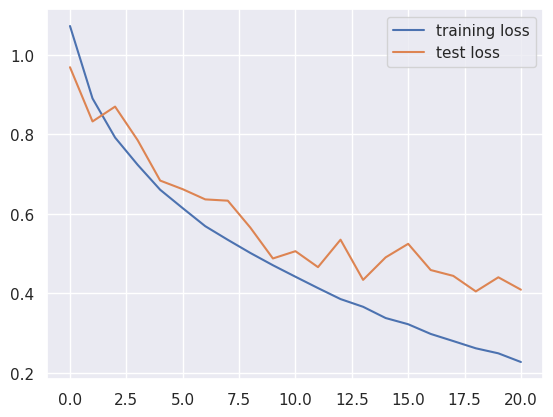

In [6]:
plt.plot(losses, label='training loss')
plt.plot(eval_losses, label='test loss')
plt.legend()
plt.show()

**Experience 1:** Finetuning the whole model

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18()
model.linear = nn.Linear(512, 4)
model.load_state_dict(torch.load('model_20.pth'))
for param in model.parameters():
    param.requires_grad = True
model.linear = nn.Linear(512, 10)
model = model.to(device)

max_epochs = 15
lr = 0.001

train_dataloader = get_dataloader('training')
test_dataloader = get_dataloader('testing', batch_size=512)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = None

train_losses, train_accs, test_losses, test_accs = train(model, train_dataloader, test_dataloader, criterion, optimizer, device, epochs=max_epochs, scheduler=scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0/14


100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


Loss: 2.3347 Acc: 0.1812
Finised epoch 0/14, loss: 2.2134, acc: 0.1600
Test metrics 0/14, loss: 2.3347, acc: 0.1812
Epoch 1/14


100%|██████████| 20/20 [00:03<00:00,  5.81it/s]


Loss: 2.0331 Acc: 0.2779
Finised epoch 1/14, loss: 1.5190, acc: 0.5300
Test metrics 1/14, loss: 2.0331, acc: 0.2779
Epoch 2/14


100%|██████████| 20/20 [00:03<00:00,  5.95it/s]


Loss: 1.8953 Acc: 0.3035
Finised epoch 2/14, loss: 1.0467, acc: 0.7200
Test metrics 2/14, loss: 1.8953, acc: 0.3035
Epoch 3/14


100%|██████████| 20/20 [00:03<00:00,  5.88it/s]


Loss: 1.8040 Acc: 0.3379
Finised epoch 3/14, loss: 0.8016, acc: 0.7800
Test metrics 3/14, loss: 1.8040, acc: 0.3379
Epoch 4/14


100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


Loss: 1.7270 Acc: 0.3645
Finised epoch 4/14, loss: 0.4342, acc: 0.9400
Test metrics 4/14, loss: 1.7270, acc: 0.3645
Epoch 5/14


100%|██████████| 20/20 [00:03<00:00,  5.91it/s]


Loss: 1.6965 Acc: 0.3909
Finised epoch 5/14, loss: 0.2778, acc: 0.9700
Test metrics 5/14, loss: 1.6965, acc: 0.3909
Epoch 6/14


100%|██████████| 20/20 [00:03<00:00,  5.91it/s]


Loss: 1.6732 Acc: 0.4068
Finised epoch 6/14, loss: 0.1380, acc: 1.0000
Test metrics 6/14, loss: 1.6732, acc: 0.4068
Epoch 7/14


100%|██████████| 20/20 [00:03<00:00,  5.92it/s]


Loss: 1.7097 Acc: 0.4057
Finised epoch 7/14, loss: 0.0889, acc: 1.0000
Test metrics 7/14, loss: 1.7097, acc: 0.4057
Epoch 8/14


100%|██████████| 20/20 [00:03<00:00,  5.87it/s]


Loss: 1.7593 Acc: 0.4017
Finised epoch 8/14, loss: 0.0967, acc: 0.9800
Test metrics 8/14, loss: 1.7593, acc: 0.4017
Epoch 9/14


100%|██████████| 20/20 [00:03<00:00,  5.87it/s]


Loss: 1.7674 Acc: 0.4053
Finised epoch 9/14, loss: 0.0548, acc: 1.0000
Test metrics 9/14, loss: 1.7674, acc: 0.4053
Epoch 10/14


100%|██████████| 20/20 [00:03<00:00,  6.01it/s]


Loss: 1.8009 Acc: 0.4009
Finised epoch 10/14, loss: 0.0563, acc: 1.0000
Test metrics 10/14, loss: 1.8009, acc: 0.4009
Epoch 11/14


100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


Loss: 1.7969 Acc: 0.4041
Finised epoch 11/14, loss: 0.0366, acc: 1.0000
Test metrics 11/14, loss: 1.7969, acc: 0.4041
Epoch 12/14


100%|██████████| 20/20 [00:03<00:00,  5.81it/s]


Loss: 1.7700 Acc: 0.4136
Finised epoch 12/14, loss: 0.0304, acc: 1.0000
Test metrics 12/14, loss: 1.7700, acc: 0.4136
Epoch 13/14


100%|██████████| 20/20 [00:03<00:00,  5.86it/s]


Loss: 1.7921 Acc: 0.4066
Finised epoch 13/14, loss: 0.0208, acc: 1.0000
Test metrics 13/14, loss: 1.7921, acc: 0.4066
Epoch 14/14


100%|██████████| 20/20 [00:03<00:00,  5.90it/s]

Loss: 1.8222 Acc: 0.4026
Finised epoch 14/14, loss: 0.0275, acc: 0.9900
Test metrics 14/14, loss: 1.8222, acc: 0.4026
Finished Training


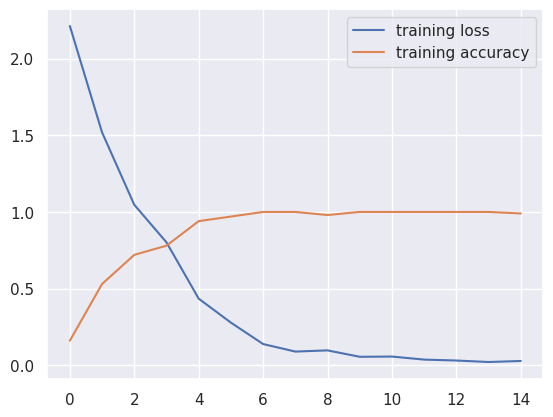

In [13]:
plt.plot(train_losses, label='training loss')
plt.plot(train_accs, label='training accuracy')
plt.legend()
plt.show()

**Experience 2:** Finetuning only the last layer

In [14]:
model = ResNet18()
model.linear = nn.Linear(512, 4)
model.load_state_dict(torch.load('model_20.pth'))
for param in model.parameters():
    param.requires_grad = False
model.linear = nn.Linear(512, 10)
model = model.to(device)

max_epochs = 50
lr = 0.001

train_dataloader = get_dataloader('training')
test_dataloader = get_dataloader('testing', batch_size=512)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = None

train_losses, train_accs, test_losses, test_accs = train(model, train_dataloader, test_dataloader, criterion, optimizer, device, epochs=max_epochs, scheduler=scheduler)


Files already downloaded and verified
Files already downloaded and verified
Epoch 0/49


100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


Loss: 2.3187 Acc: 0.1340
Finised epoch 0/49, loss: 2.3694, acc: 0.1200
Test metrics 0/49, loss: 2.3187, acc: 0.1340
Epoch 1/49


100%|██████████| 20/20 [00:03<00:00,  5.75it/s]


Loss: 2.2817 Acc: 0.1760
Finised epoch 1/49, loss: 2.1493, acc: 0.1900
Test metrics 1/49, loss: 2.2817, acc: 0.1760
Epoch 2/49


100%|██████████| 20/20 [00:03<00:00,  5.91it/s]


Loss: 2.1718 Acc: 0.2063
Finised epoch 2/49, loss: 2.0679, acc: 0.1700
Test metrics 2/49, loss: 2.1718, acc: 0.2063
Epoch 3/49


100%|██████████| 20/20 [00:03<00:00,  5.79it/s]


Loss: 2.1325 Acc: 0.2078
Finised epoch 3/49, loss: 1.9647, acc: 0.3100
Test metrics 3/49, loss: 2.1325, acc: 0.2078
Epoch 4/49


100%|██████████| 20/20 [00:03<00:00,  5.95it/s]


Loss: 2.0978 Acc: 0.2394
Finised epoch 4/49, loss: 1.8796, acc: 0.3100
Test metrics 4/49, loss: 2.0978, acc: 0.2394
Epoch 5/49


100%|██████████| 20/20 [00:03<00:00,  5.86it/s]


Loss: 2.0736 Acc: 0.2391
Finised epoch 5/49, loss: 1.8776, acc: 0.3300
Test metrics 5/49, loss: 2.0736, acc: 0.2391
Epoch 6/49


100%|██████████| 20/20 [00:03<00:00,  6.01it/s]


Loss: 2.0416 Acc: 0.2584
Finised epoch 6/49, loss: 1.8073, acc: 0.3500
Test metrics 6/49, loss: 2.0416, acc: 0.2584
Epoch 7/49


100%|██████████| 20/20 [00:03<00:00,  5.94it/s]


Loss: 2.0585 Acc: 0.2577
Finised epoch 7/49, loss: 1.7177, acc: 0.4000
Test metrics 7/49, loss: 2.0585, acc: 0.2577
Epoch 8/49


100%|██████████| 20/20 [00:03<00:00,  5.84it/s]


Loss: 2.0605 Acc: 0.2639
Finised epoch 8/49, loss: 1.7433, acc: 0.4200
Test metrics 8/49, loss: 2.0605, acc: 0.2639
Epoch 9/49


100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


Loss: 2.0211 Acc: 0.2797
Finised epoch 9/49, loss: 1.6806, acc: 0.4700
Test metrics 9/49, loss: 2.0211, acc: 0.2797
Epoch 10/49


100%|██████████| 20/20 [00:03<00:00,  5.98it/s]


Loss: 2.0371 Acc: 0.2662
Finised epoch 10/49, loss: 1.6821, acc: 0.4300
Test metrics 10/49, loss: 2.0371, acc: 0.2662
Epoch 11/49


100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


Loss: 2.0155 Acc: 0.2808
Finised epoch 11/49, loss: 1.6227, acc: 0.4500
Test metrics 11/49, loss: 2.0155, acc: 0.2808
Epoch 12/49


100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


Loss: 2.0084 Acc: 0.2862
Finised epoch 12/49, loss: 1.6363, acc: 0.4700
Test metrics 12/49, loss: 2.0084, acc: 0.2862
Epoch 13/49


100%|██████████| 20/20 [00:03<00:00,  5.90it/s]


Loss: 2.0142 Acc: 0.2795
Finised epoch 13/49, loss: 1.6446, acc: 0.4600
Test metrics 13/49, loss: 2.0142, acc: 0.2795
Epoch 14/49


100%|██████████| 20/20 [00:03<00:00,  6.05it/s]


Loss: 1.9859 Acc: 0.2941
Finised epoch 14/49, loss: 1.5884, acc: 0.4500
Test metrics 14/49, loss: 1.9859, acc: 0.2941
Epoch 15/49


100%|██████████| 20/20 [00:03<00:00,  5.65it/s]


Loss: 1.9791 Acc: 0.2984
Finised epoch 15/49, loss: 1.5306, acc: 0.5000
Test metrics 15/49, loss: 1.9791, acc: 0.2984
Epoch 16/49


100%|██████████| 20/20 [00:03<00:00,  5.94it/s]


Loss: 2.0093 Acc: 0.2898
Finised epoch 16/49, loss: 1.4806, acc: 0.5200
Test metrics 16/49, loss: 2.0093, acc: 0.2898
Epoch 17/49


100%|██████████| 20/20 [00:03<00:00,  5.94it/s]


Loss: 1.9867 Acc: 0.3032
Finised epoch 17/49, loss: 1.4653, acc: 0.5500
Test metrics 17/49, loss: 1.9867, acc: 0.3032
Epoch 18/49


100%|██████████| 20/20 [00:03<00:00,  5.93it/s]


Loss: 1.9926 Acc: 0.2859
Finised epoch 18/49, loss: 1.4753, acc: 0.5500
Test metrics 18/49, loss: 1.9926, acc: 0.2859
Epoch 19/49


100%|██████████| 20/20 [00:03<00:00,  5.86it/s]


Loss: 1.9720 Acc: 0.3027
Finised epoch 19/49, loss: 1.4422, acc: 0.5700
Test metrics 19/49, loss: 1.9720, acc: 0.3027
Epoch 20/49


100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


Loss: 2.0199 Acc: 0.2899
Finised epoch 20/49, loss: 1.3972, acc: 0.5800
Test metrics 20/49, loss: 2.0199, acc: 0.2899
Epoch 21/49


100%|██████████| 20/20 [00:03<00:00,  5.84it/s]


Loss: 1.9923 Acc: 0.2936
Finised epoch 21/49, loss: 1.4555, acc: 0.5100
Test metrics 21/49, loss: 1.9923, acc: 0.2936
Epoch 22/49


100%|██████████| 20/20 [00:03<00:00,  5.93it/s]


Loss: 1.9845 Acc: 0.3057
Finised epoch 22/49, loss: 1.4261, acc: 0.6100
Test metrics 22/49, loss: 1.9845, acc: 0.3057
Epoch 23/49


100%|██████████| 20/20 [00:03<00:00,  5.81it/s]


Loss: 1.9749 Acc: 0.3006
Finised epoch 23/49, loss: 1.4187, acc: 0.6000
Test metrics 23/49, loss: 1.9749, acc: 0.3006
Epoch 24/49


100%|██████████| 20/20 [00:03<00:00,  5.82it/s]


Loss: 1.9700 Acc: 0.2987
Finised epoch 24/49, loss: 1.3551, acc: 0.6100
Test metrics 24/49, loss: 1.9700, acc: 0.2987
Epoch 25/49


100%|██████████| 20/20 [00:03<00:00,  5.90it/s]


Loss: 1.9551 Acc: 0.3127
Finised epoch 25/49, loss: 1.3307, acc: 0.6100
Test metrics 25/49, loss: 1.9551, acc: 0.3127
Epoch 26/49


100%|██████████| 20/20 [00:03<00:00,  5.82it/s]


Loss: 1.9415 Acc: 0.3156
Finised epoch 26/49, loss: 1.3433, acc: 0.6600
Test metrics 26/49, loss: 1.9415, acc: 0.3156
Epoch 27/49


100%|██████████| 20/20 [00:03<00:00,  5.93it/s]


Loss: 1.9936 Acc: 0.2937
Finised epoch 27/49, loss: 1.3459, acc: 0.5500
Test metrics 27/49, loss: 1.9936, acc: 0.2937
Epoch 28/49


100%|██████████| 20/20 [00:03<00:00,  5.84it/s]


Loss: 1.9555 Acc: 0.3085
Finised epoch 28/49, loss: 1.3607, acc: 0.5300
Test metrics 28/49, loss: 1.9555, acc: 0.3085
Epoch 29/49


100%|██████████| 20/20 [00:03<00:00,  5.90it/s]


Loss: 1.9980 Acc: 0.3017
Finised epoch 29/49, loss: 1.3447, acc: 0.5600
Test metrics 29/49, loss: 1.9980, acc: 0.3017
Epoch 30/49


100%|██████████| 20/20 [00:03<00:00,  5.79it/s]


Loss: 1.9514 Acc: 0.3160
Finised epoch 30/49, loss: 1.2800, acc: 0.6700
Test metrics 30/49, loss: 1.9514, acc: 0.3160
Epoch 31/49


100%|██████████| 20/20 [00:03<00:00,  5.91it/s]


Loss: 1.9514 Acc: 0.3207
Finised epoch 31/49, loss: 1.2615, acc: 0.7200
Test metrics 31/49, loss: 1.9514, acc: 0.3207
Epoch 32/49


100%|██████████| 20/20 [00:03<00:00,  5.93it/s]


Loss: 1.9728 Acc: 0.3136
Finised epoch 32/49, loss: 1.2780, acc: 0.6100
Test metrics 32/49, loss: 1.9728, acc: 0.3136
Epoch 33/49


100%|██████████| 20/20 [00:03<00:00,  5.97it/s]


Loss: 1.9865 Acc: 0.3143
Finised epoch 33/49, loss: 1.2822, acc: 0.5900
Test metrics 33/49, loss: 1.9865, acc: 0.3143
Epoch 34/49


100%|██████████| 20/20 [00:03<00:00,  5.81it/s]


Loss: 1.9680 Acc: 0.3150
Finised epoch 34/49, loss: 1.1724, acc: 0.6800
Test metrics 34/49, loss: 1.9680, acc: 0.3150
Epoch 35/49


100%|██████████| 20/20 [00:03<00:00,  5.86it/s]


Loss: 1.9594 Acc: 0.3170
Finised epoch 35/49, loss: 1.2053, acc: 0.6200
Test metrics 35/49, loss: 1.9594, acc: 0.3170
Epoch 36/49


100%|██████████| 20/20 [00:03<00:00,  5.94it/s]


Loss: 1.9627 Acc: 0.3164
Finised epoch 36/49, loss: 1.2303, acc: 0.6800
Test metrics 36/49, loss: 1.9627, acc: 0.3164
Epoch 37/49


100%|██████████| 20/20 [00:03<00:00,  5.93it/s]


Loss: 1.9647 Acc: 0.3100
Finised epoch 37/49, loss: 1.2154, acc: 0.6500
Test metrics 37/49, loss: 1.9647, acc: 0.3100
Epoch 38/49


100%|██████████| 20/20 [00:03<00:00,  5.86it/s]


Loss: 1.9409 Acc: 0.3270
Finised epoch 38/49, loss: 1.1228, acc: 0.7100
Test metrics 38/49, loss: 1.9409, acc: 0.3270
Epoch 39/49


100%|██████████| 20/20 [00:03<00:00,  5.99it/s]


Loss: 1.9201 Acc: 0.3285
Finised epoch 39/49, loss: 1.1909, acc: 0.6700
Test metrics 39/49, loss: 1.9201, acc: 0.3285
Epoch 40/49


100%|██████████| 20/20 [00:03<00:00,  5.71it/s]


Loss: 1.9715 Acc: 0.3187
Finised epoch 40/49, loss: 1.1846, acc: 0.6300
Test metrics 40/49, loss: 1.9715, acc: 0.3187
Epoch 41/49


100%|██████████| 20/20 [00:03<00:00,  5.87it/s]


Loss: 1.9515 Acc: 0.3223
Finised epoch 41/49, loss: 1.1494, acc: 0.6800
Test metrics 41/49, loss: 1.9515, acc: 0.3223
Epoch 42/49


100%|██████████| 20/20 [00:03<00:00,  5.85it/s]


Loss: 1.9185 Acc: 0.3341
Finised epoch 42/49, loss: 1.0662, acc: 0.7500
Test metrics 42/49, loss: 1.9185, acc: 0.3341
Epoch 43/49


100%|██████████| 20/20 [00:03<00:00,  6.00it/s]


Loss: 1.9468 Acc: 0.3152
Finised epoch 43/49, loss: 1.1512, acc: 0.6700
Test metrics 43/49, loss: 1.9468, acc: 0.3152
Epoch 44/49


100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


Loss: 1.9325 Acc: 0.3373
Finised epoch 44/49, loss: 1.1107, acc: 0.6900
Test metrics 44/49, loss: 1.9325, acc: 0.3373
Epoch 45/49


100%|██████████| 20/20 [00:03<00:00,  5.85it/s]


Loss: 1.9563 Acc: 0.3284
Finised epoch 45/49, loss: 1.0822, acc: 0.7700
Test metrics 45/49, loss: 1.9563, acc: 0.3284
Epoch 46/49


100%|██████████| 20/20 [00:03<00:00,  5.82it/s]


Loss: 1.9495 Acc: 0.3247
Finised epoch 46/49, loss: 1.0753, acc: 0.7600
Test metrics 46/49, loss: 1.9495, acc: 0.3247
Epoch 47/49


100%|██████████| 20/20 [00:03<00:00,  5.92it/s]


Loss: 1.9475 Acc: 0.3327
Finised epoch 47/49, loss: 1.1215, acc: 0.6300
Test metrics 47/49, loss: 1.9475, acc: 0.3327
Epoch 48/49


100%|██████████| 20/20 [00:03<00:00,  5.80it/s]


Loss: 1.9330 Acc: 0.3306
Finised epoch 48/49, loss: 1.0832, acc: 0.7500
Test metrics 48/49, loss: 1.9330, acc: 0.3306
Epoch 49/49


100%|██████████| 20/20 [00:03<00:00,  5.83it/s]

Loss: 1.9198 Acc: 0.3388
Finised epoch 49/49, loss: 1.0193, acc: 0.7600
Test metrics 49/49, loss: 1.9198, acc: 0.3388
Finished Training


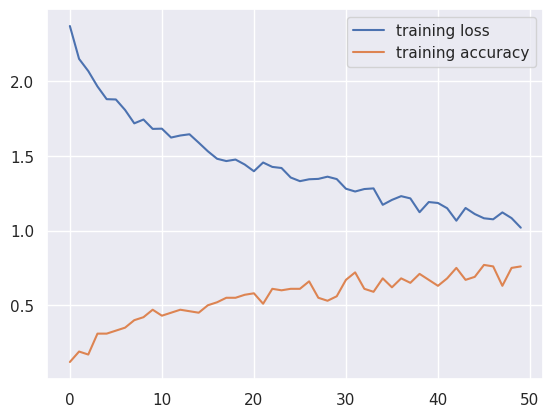

In [15]:
plt.plot(train_losses, label='training loss')
plt.plot(train_accs, label='training accuracy')
plt.legend()
plt.show()